# Анализ рисков

Данные взяты c Kaggle: https://www.kaggle.com/datasets/kanishkme/bank-loan-risk-analysis

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, log_loss 
from sklearn.metrics import r2_score,f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

Цветовая схема:


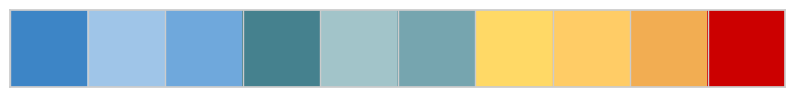

In [88]:
#whitegrid,darkgrid,white,ticks,white
sns.set_theme(style="whitegrid", font_scale=1.2)#, font_scale=2
plt.rcParams["figure.figsize"] = (20,10)
my_colors = ['#3d85c6', '#9fc5e8', '#6fa8dc', '#45818e', '#a2c4c9', '#76a5af', '#ffd966', '#ffcc66', '#f2ad52', '#cc0000']
#pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

print("Цветовая схема:")
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [4]:
#увеличиваю отображение таблиц в ячейках вывода, чтобы показывало все данные
pd.options.display.max_rows = 215
pd.options.display.max_columns = 122

In [5]:
DATA_DIR = Path("D:/Документы/Python/тестовые/СКМ")

# План действий:
### - EDA (разведочный анализ данных)
### - EDA c преобразованиями (небольшие преобразования для интерпритации данных)
### - Предобработка данных 
### - Обучение модели и предсказание

# EDA

Выясню основные характеристики людей берущих кредиты и кто чаще всего не возвращает

In [8]:
description = pd.read_csv(DATA_DIR/"columns_description.csv" ) #объяснение значений колонок

In [72]:
#description

### колонка TARGET  - Целевая переменная (1 - клиент с трудностями с оплатой: у него/нее была просрочка платежа более чем на Х дней хотя бы по одному из первых Y платежей по кредиту в нашей выборке, 0 - все остальные случаи)

In [6]:
data  = pd.read_csv(DATA_DIR/"application_data.csv" )

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data_pr  = pd.read_csv(DATA_DIR/"previous_application.csv" )
data_pr.columns = data_pr.columns.str.lower()

In [64]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    sk_id_curr                    int64  
 1    target                        int64  
 2    name_contract_type            object 
 3    code_gender                   object 
 4    flag_own_car                  object 
 5    flag_own_realty               object 
 6    cnt_children                  int64  
 7    amt_income_total              float64
 8    amt_credit                    float64
 9    amt_annuity                   float64
 10   amt_goods_price               float64
 11   name_type_suite               object 
 12   name_income_type              object 
 13   name_education_type           object 
 14   name_family_status            object 
 15   name_housing_type             object 
 16   region_population_relative    float64
 17   days_birth                    int64  
 18   da

In [65]:
data_pr.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   sk_id_prev                   1670214 non-null  int64  
 1   sk_id_curr                   1670214 non-null  int64  
 2   name_contract_type           1670214 non-null  object 
 3   amt_annuity                  1297979 non-null  float64
 4   amt_application              1670214 non-null  float64
 5   amt_credit                   1670213 non-null  float64
 6   amt_down_payment             774370 non-null   float64
 7   amt_goods_price              1284699 non-null  float64
 8   weekday_appr_process_start   1670214 non-null  object 
 9   hour_appr_process_start      1670214 non-null  int64  
 10  flag_last_appl_per_contract  1670214 non-null  object 
 11  nflag_last_appl_in_day       1670214 non-null  int64  
 12  rate_down_payment            774370 non-nu

In [66]:
data.describe().applymap(lambda x: f"{x:0.3f}")

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,totalarea_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,307511.000,307511.000,307511.000,307511.000,307511.000,307499.000,307233.000,307511.000,307511.000,307511.000,307511.000,307511.000,104582.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307509.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,134133.000,306851.000,246546.000,151450.000,127568.000,157504.000,103023.000,92646.000,143620.000,152683.000,154491.000,98869.000,124921.000,97312.000,153161.000,93997.000,137829.000,151450.000,127568.000,157504.000,103023.000,92646.000,143620.000,152683.000,154491.000,98869.000,124921.000,97312.000,153161.000,93997.000,137829.000,151450.000,127568.000,157504.000,103023.000,92646.000,143620.000,152683.000,154491.000,98869.000,124921.000,97312.000,153161.000,93997.000,137829.000,159080.000,306490.000,306490.000,306490.000,306490.000,307510.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,265992.000,265992.000,265992.000,265992.000,265992.000,265992.000
mean,278180.519,0.081,0.417,168797.919,599026.000,27108.574,538396.207,0.021,-16036.995,63815.046,-4986.120,-2994.202,12.061,1.000,0.820,0.199,0.998,0.281,0.057,2.153,2.052,2.032,12.063,0.015,0.051,0.041,0.078,0.230,0.180,0.502,0.514,0.511,0.117,0.088,0.978,0.752,0.045,0.079,0.150,0.226,0.232,0.066,0.101,0.107,0.009,0.028,0.114,0.088,0.977,0.760,0.043,0.074,0.145,0.222,0.228,0.065,0.106,0.106,0.008,0.027,0.118,0.088,0.978,0.756,0.045,0.078,0.149,0.226,0.232,0.067,0.102,0.109,0.009,0.028,0.103,1.422,0.143,1.405,0.100,-962.859,0.000,0.710,0.000,0.015,0.088,0.000,0.081,0.004,0.000,0.004,0.000,0.004,0.003,0.001,0.010,0.000,0.008,0.001,0.001,0.000,0.006,0.007,0.034,0.267,0.265,1.900
std,102790.175,0.272,0.722,237123.146,402490.777,14493.737,369446.461,0.014,4363.989,141275.767,3522.886,1509.450,11.945,0.002,0.384,0.400,0.043,0.450,0.231,0.911,0.509,0.503,3.266,0.122,0.220,0.197,0.268,0.421,0.384,0.211,0.191,0.195,

#### есть выбросы во всех некатегориальных колонках 

In [67]:
data_pr.describe().applymap(lambda x: f"{x:0.3f}")

,sk_id_prev,sk_id_curr,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,days_decision,sellerplace_area,cnt_payment,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
count,1670214.000,1670214.000,1297979.000,1670214.000,1670213.000,774370.000,1284699.000,1670214.000,1670214.000,774370.000,5951.000,5951.000,1670214.000,1670214.000,1297984.000,997149.000,997149.000,997149.000,997149.000,997149.000,997149.000
mean,1923089.135,278357.174,15955.121,175233.860,196114.021,6697.402,227847.279,12.484,0.996,0.080,0.188,0.774,-880.680,313.951,16.054,342209.855,13826.269,33767.774,76582.403,81992.344,0.333
std,532597.959,102814.824,14782.137,292779.762,318574.617,20921.495,315396.558,3.334,0.059,0.108,0.088,0.101,779.100,7127.443,14.567,88916.116,72444.870,106857.035,149647.415,153303.517,0.471
min,1000001.000,100001.000,0.000,0.000,0.000,-0.900,0.000,0.000,0.000,-0.000,0.035,0.373,-2922.000,-1.000,0.000,-2922.000,-2892.000,-2801.000,-2889.000,-2874.000,0.000
25%,1461857.250,189329.000,6321.780,18720.000,24160.500,0.000,50841.000,10.000,1.000,0.000,0.161,0.716,-1300.000,-1.000,6.000,365243.000,-1628.000,-1242.000,-1314.000,-1270.000,0.000
50%,1923110.500,278714.500,11250.000,71046.000,80541.000,1638.000,112320.000,12.000,1.000,0.052,0.189,0.835,-581.000,3.000,12.000,365243.000,-831.000,-361.000,-537.000,-499.000,0.000
75%,2384279.750,367514.000,20658.420,180360.000,216418.500,7740.000,234000.000,15.000,1.000,0.109,0.193,0.853,-280.000,82.000,24.000,365243.000,-411.000,129.000,-74.000,-44.000,1.000
max,2845382.000,456255.000,418058.145,6905160.000,6905160.000,3060045.000,6905160.000,23.000,1.000,1.000,1.000,1.000,-1.000,4000000.000,84.000,365243.000,365243.000,365243.000,365243.000,365243.000,1.000


#### есть выбросы почти во всех некатегориальных колонках 

In [9]:
data.drop_duplicates(inplace=True)
data_pr.drop_duplicates(inplace=True)

In [90]:
#round(data.isnull().sum()/len(data)*100, 2) #процент пропущенных значений

In [10]:
def find_missing_values(df, percent):
    '''выводит названия колонок 
    в которых процент пропущенных больше границы '''
    print(f'Колонки с долей пропущенных значений больше {percent}%')
    lost_col = [] #сохраняю колонки где пропуски, чтобы была возможность быстроо удалить их  
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())*100
        if pct_missing > percent:
            lost_col.append(col)
            print('{} - {}%'.format(col, round(pct_missing, 4)))
    print(f'Общее количество колонок с пропусками - {len(lost_col)}')        
    return lost_col

In [11]:
lost_col_data = find_missing_values(data, 50)

Колонки с долей пропущенных значений больше 50%
own_car_age - 65.9908%
ext_source_1 - 56.3811%
apartments_avg - 50.7497%
basementarea_avg - 58.516%
years_build_avg - 66.4978%
commonarea_avg - 69.8723%
elevators_avg - 53.296%
entrances_avg - 50.3488%
floorsmin_avg - 67.8486%
landarea_avg - 59.3767%
livingapartments_avg - 68.355%
livingarea_avg - 50.1933%
nonlivingapartments_avg - 69.433%
nonlivingarea_avg - 55.1792%
apartments_mode - 50.7497%
basementarea_mode - 58.516%
years_build_mode - 66.4978%
commonarea_mode - 69.8723%
elevators_mode - 53.296%
entrances_mode - 50.3488%
floorsmin_mode - 67.8486%
landarea_mode - 59.3767%
livingapartments_mode - 68.355%
livingarea_mode - 50.1933%
nonlivingapartments_mode - 69.433%
nonlivingarea_mode - 55.1792%
apartments_medi - 50.7497%
basementarea_medi - 58.516%
years_build_medi - 66.4978%
commonarea_medi - 69.8723%
elevators_medi - 53.296%
entrances_medi - 50.3488%
floorsmin_medi - 67.8486%
landarea_medi - 59.3767%
livingapartments_medi - 68.355%
l

#### Пропуски относятся к колонкам с описанием домов, дальше проверю можно ли удалять

In [12]:
lost_col_data_pr = find_missing_values(data_pr, 50)

Колонки с долей пропущенных значений больше 50%
amt_down_payment - 53.6365%
rate_down_payment - 53.6365%
rate_interest_primary - 99.6437%
rate_interest_privileged - 99.6437%
Общее количество колонок с пропусками - 4


#### в rate_interest_primary, rate_interest_privileged точно под удаление, тк пропусков 100%

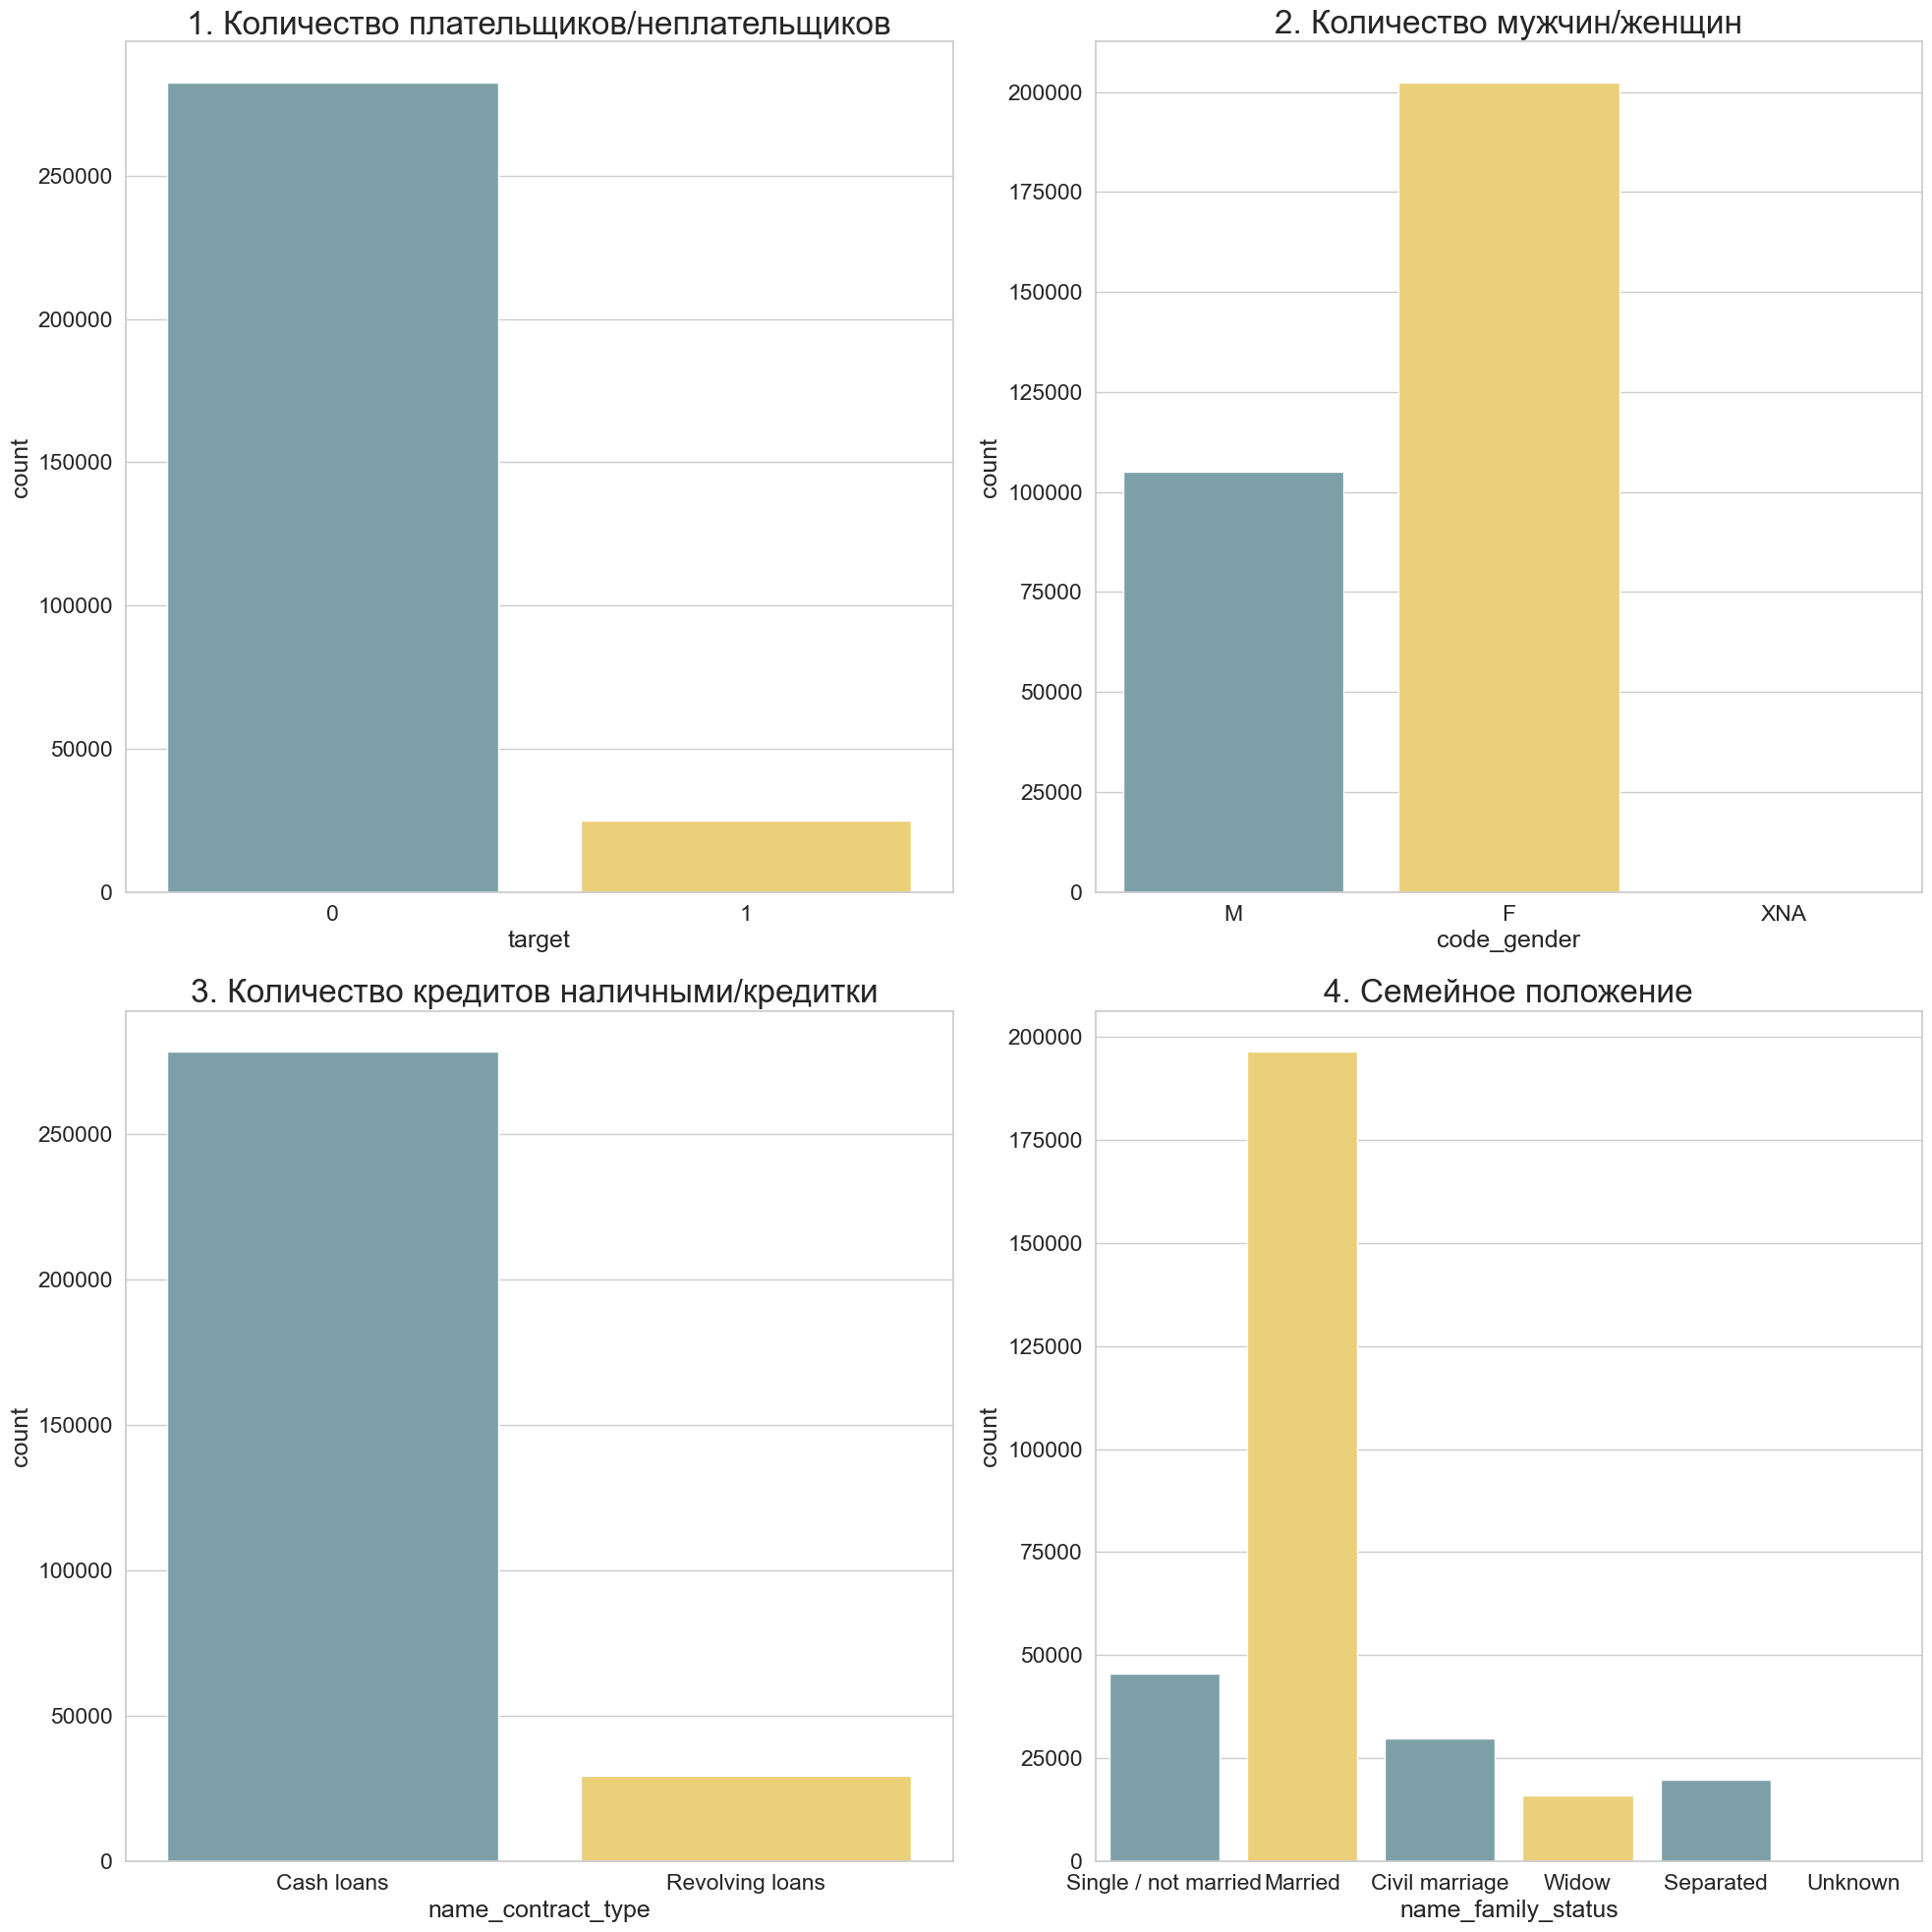

In [51]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plt.title('1. Количество плательщиков/неплательщиков', size=24)
sns.countplot(data=data, x='target',palette=my_colors[5:7])

plt.subplot(2,2,2)
plt.title('2. Количество мужчин/женщин', size=24)
sns.countplot(data=data, x='code_gender', palette=my_colors[5:7])

plt.subplot(2,2,3)
plt.title('3. Количество кредитов наличными/кредитки ', size=24)
sns.countplot(data=data, x='name_contract_type', palette=my_colors[5:7])

plt.subplot(2,2,4)
plt.title('4. Семейное положение', size=24)
sns.countplot(data=data, x='name_family_status', palette=my_colors[5:7])


plt.tight_layout()

#### 1. Преобладает количество плательщиков, что не удивительно, ~25000 неплательщиков
#### 2.  Женщин в выборке больше, почти в 2 раза
#### 3. Кредитов наличными намного больше, чем возобновляемых
#### 4. В основном кредиты берут женатые, с большим отрывом - одинокие

Text(0.5, 1.0, 'На что берут кредиты')

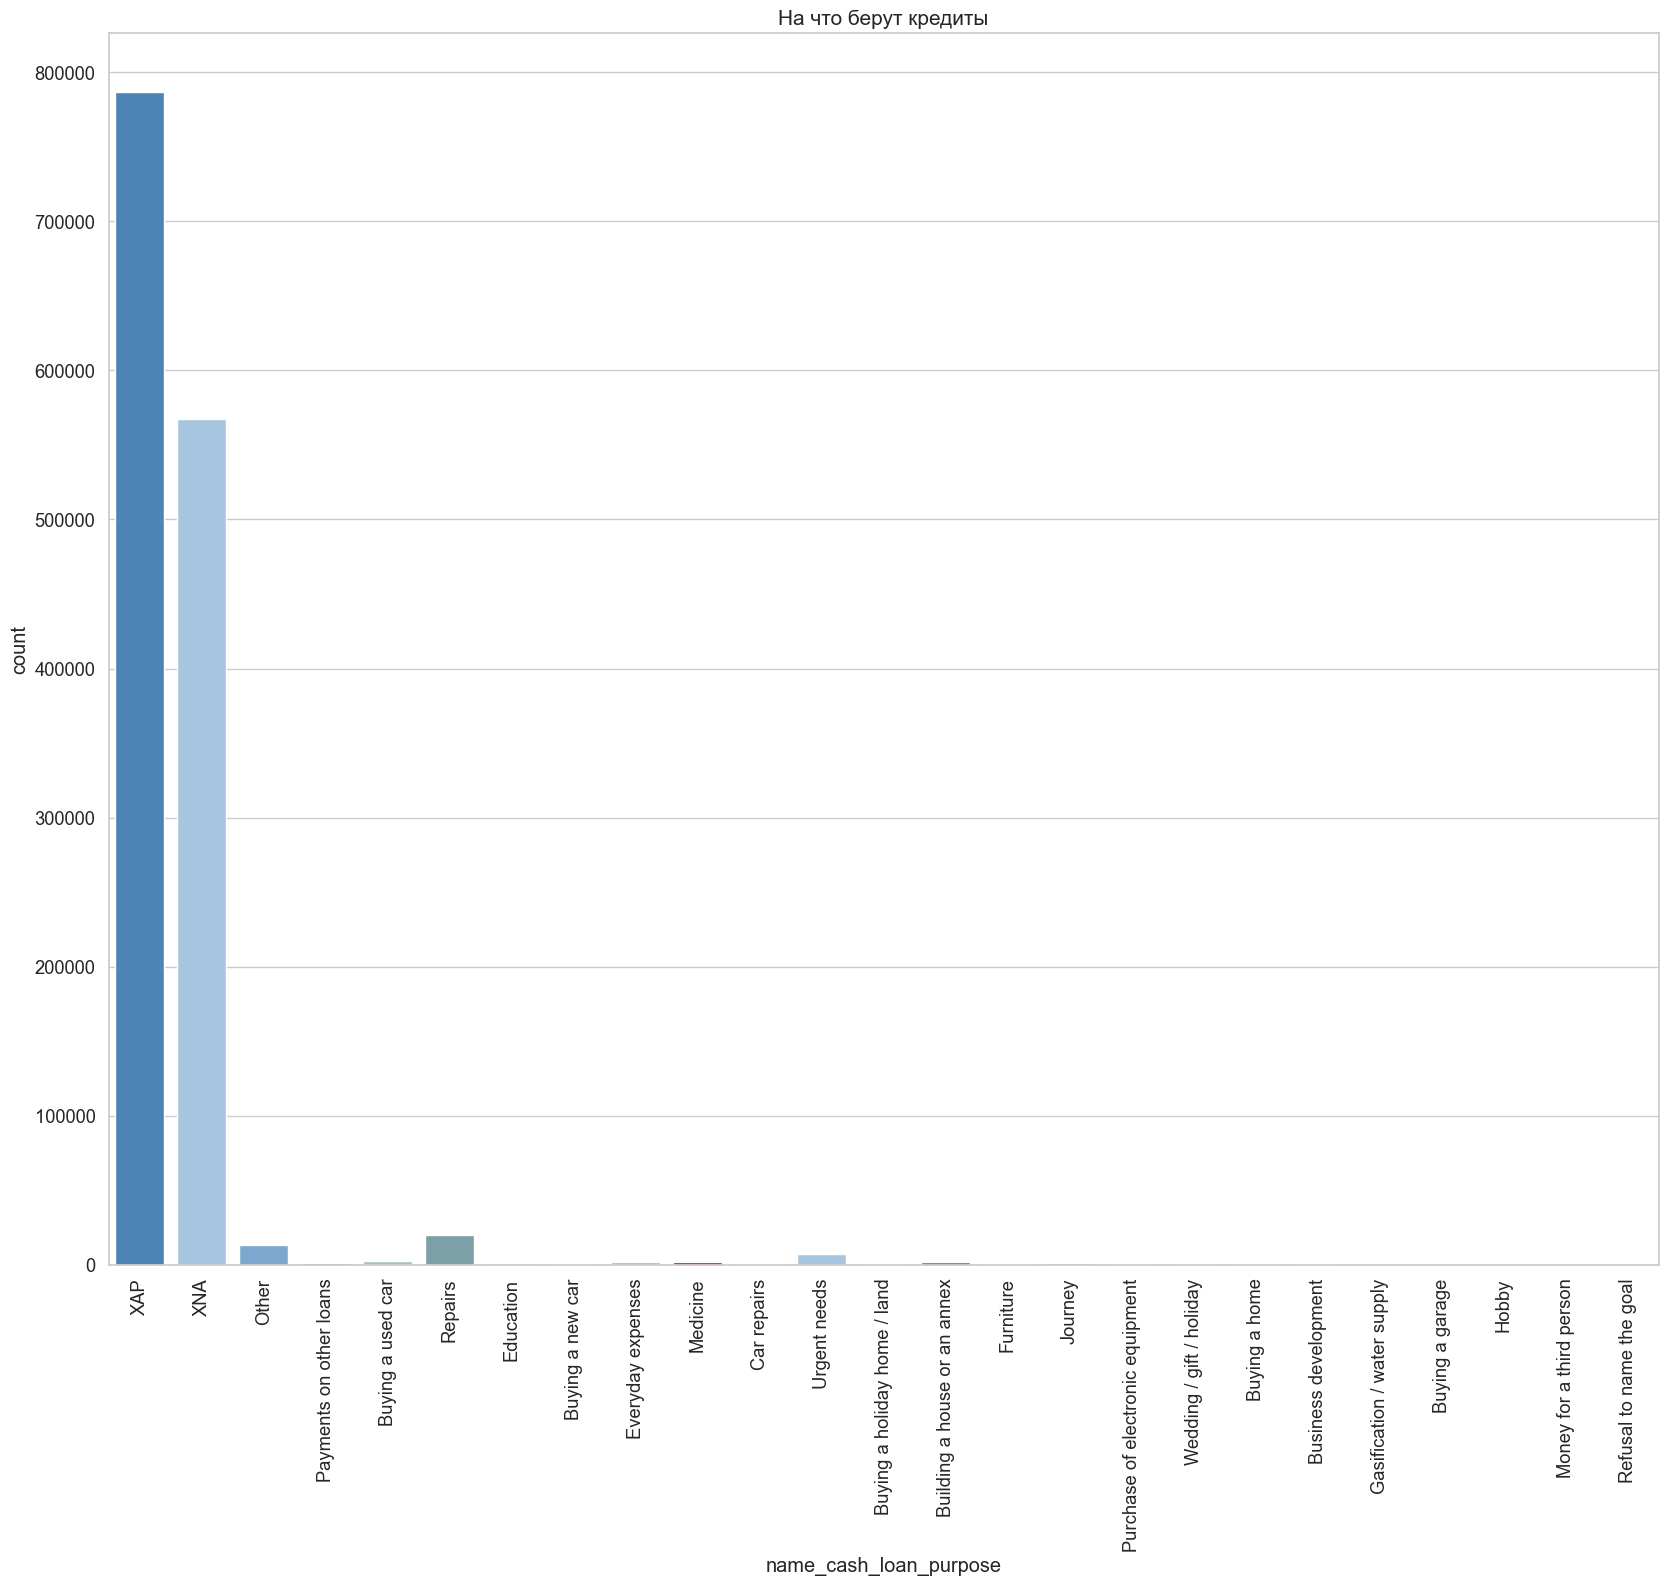

In [99]:
plt.figure(figsize=(20,16))
sns.countplot(data=df_for_grafic, x='name_cash_loan_purpose', palette=my_colors)
plt.xticks(rotation=90)
plt.title('На что берут кредиты', size=15)

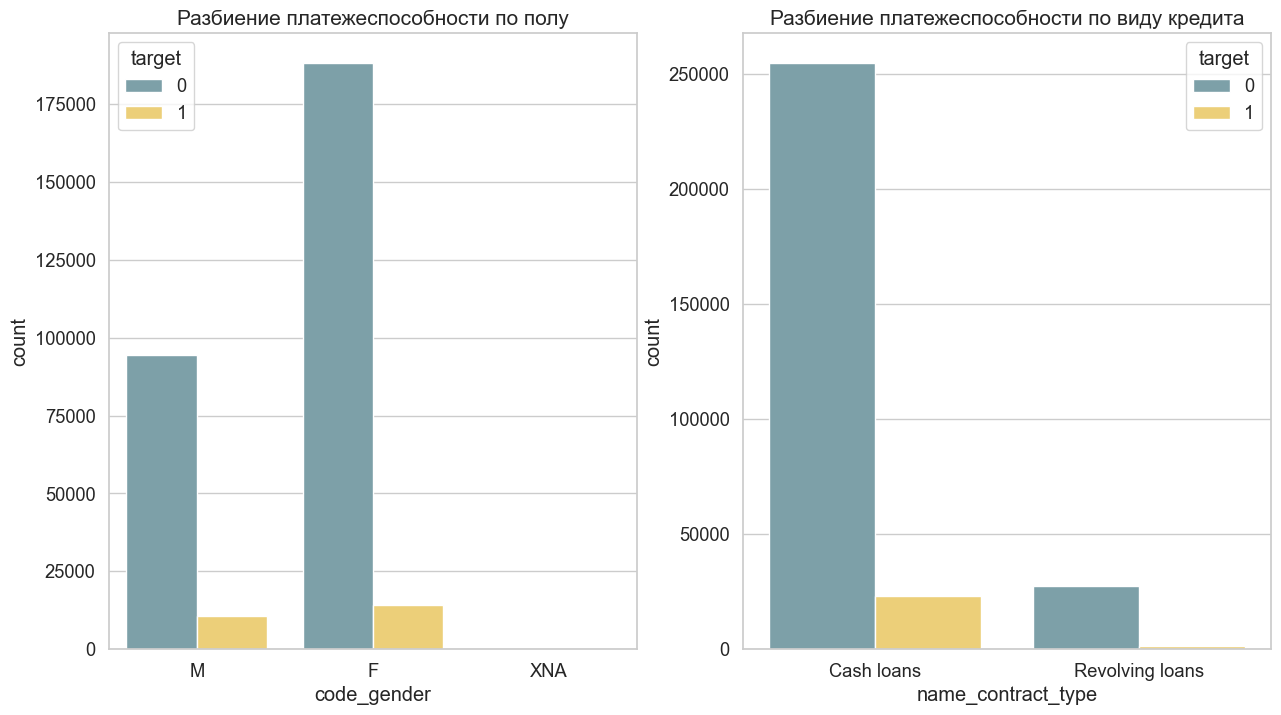

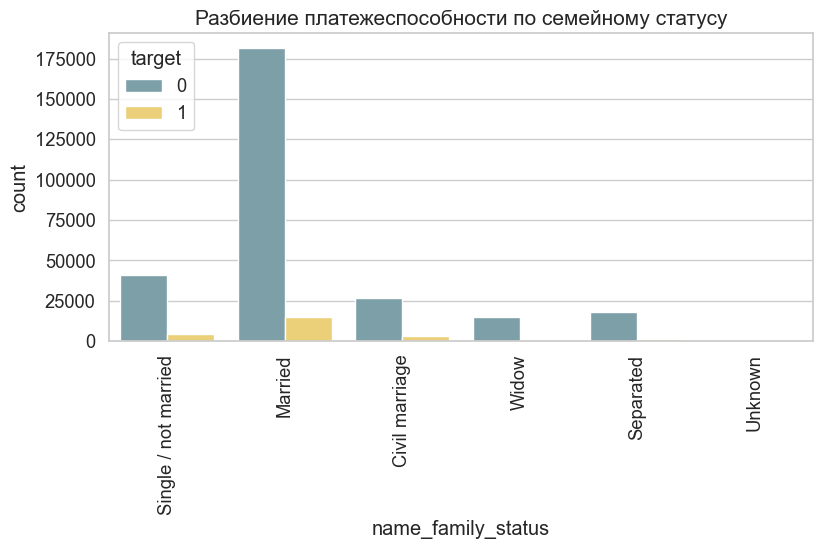

In [89]:
plt.figure(figsize=(15,20))

plt.subplot(2,2,1)
sns.countplot(data=data, x='code_gender', hue='target', palette=my_colors[5:7] )
plt.title('Разбиение платежеспособности по полу', size=15)

plt.subplot(2,2,2)
sns.countplot(data=data, x='name_contract_type', hue='target', palette=my_colors[5:7])
plt.title('Разбиение платежеспособности по виду кредита', size=15)
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

plt.subplot(2,2,3)
sns.countplot(data=data, x='name_family_status', hue='target', palette=my_colors[5:7])
plt.xticks(rotation=90)
plt.title('Разбиение платежеспособности по семейному статусу', size=15)
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

#### Несмотря на то что, женщины берут больше кредитов, среди них неплательщиков почти столько же сколько мужчин, что говорит о том, что женщины чаще возвращают кредит

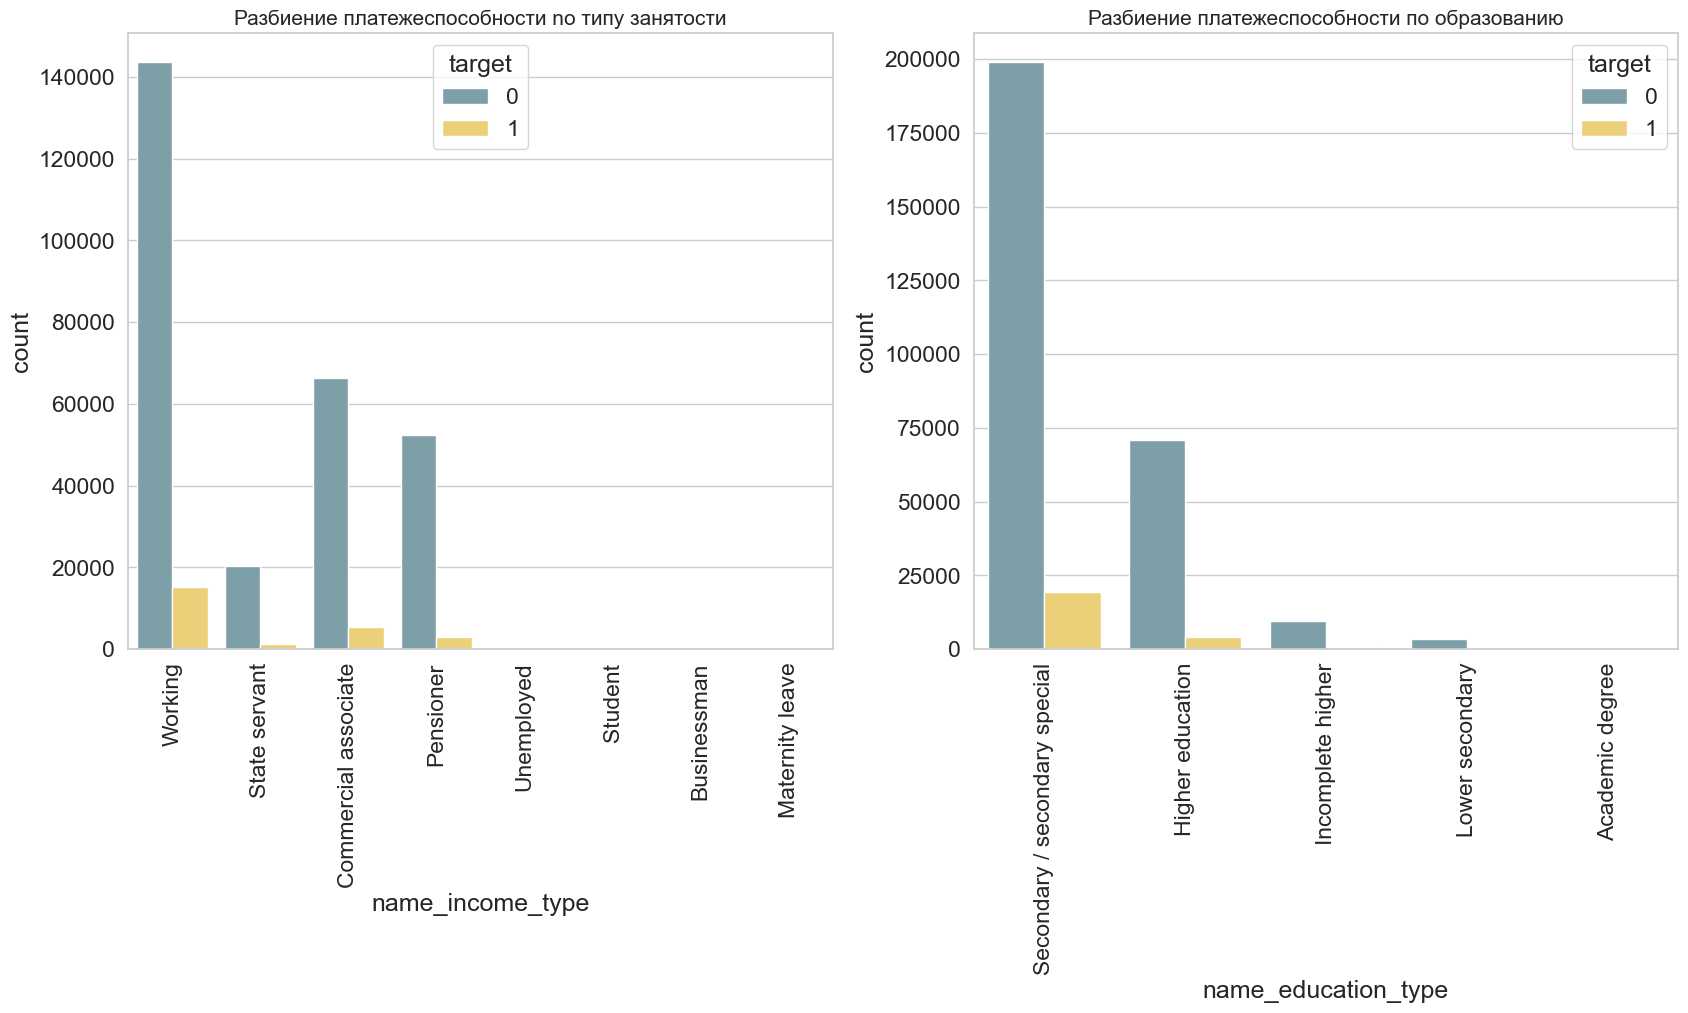

In [81]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.countplot(data=data, x='name_income_type', hue='target', palette=my_colors[5:7] )
plt.xticks(rotation=90)
plt.title('Разбиение платежеспособности nо типу занятости', size=15)

plt.subplot(2,2,2)
sns.countplot(data=data, x='name_education_type', hue='target', palette=my_colors[5:7])
plt.xticks(rotation=90)
plt.title('Разбиение платежеспособности по образованию', size=15)
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

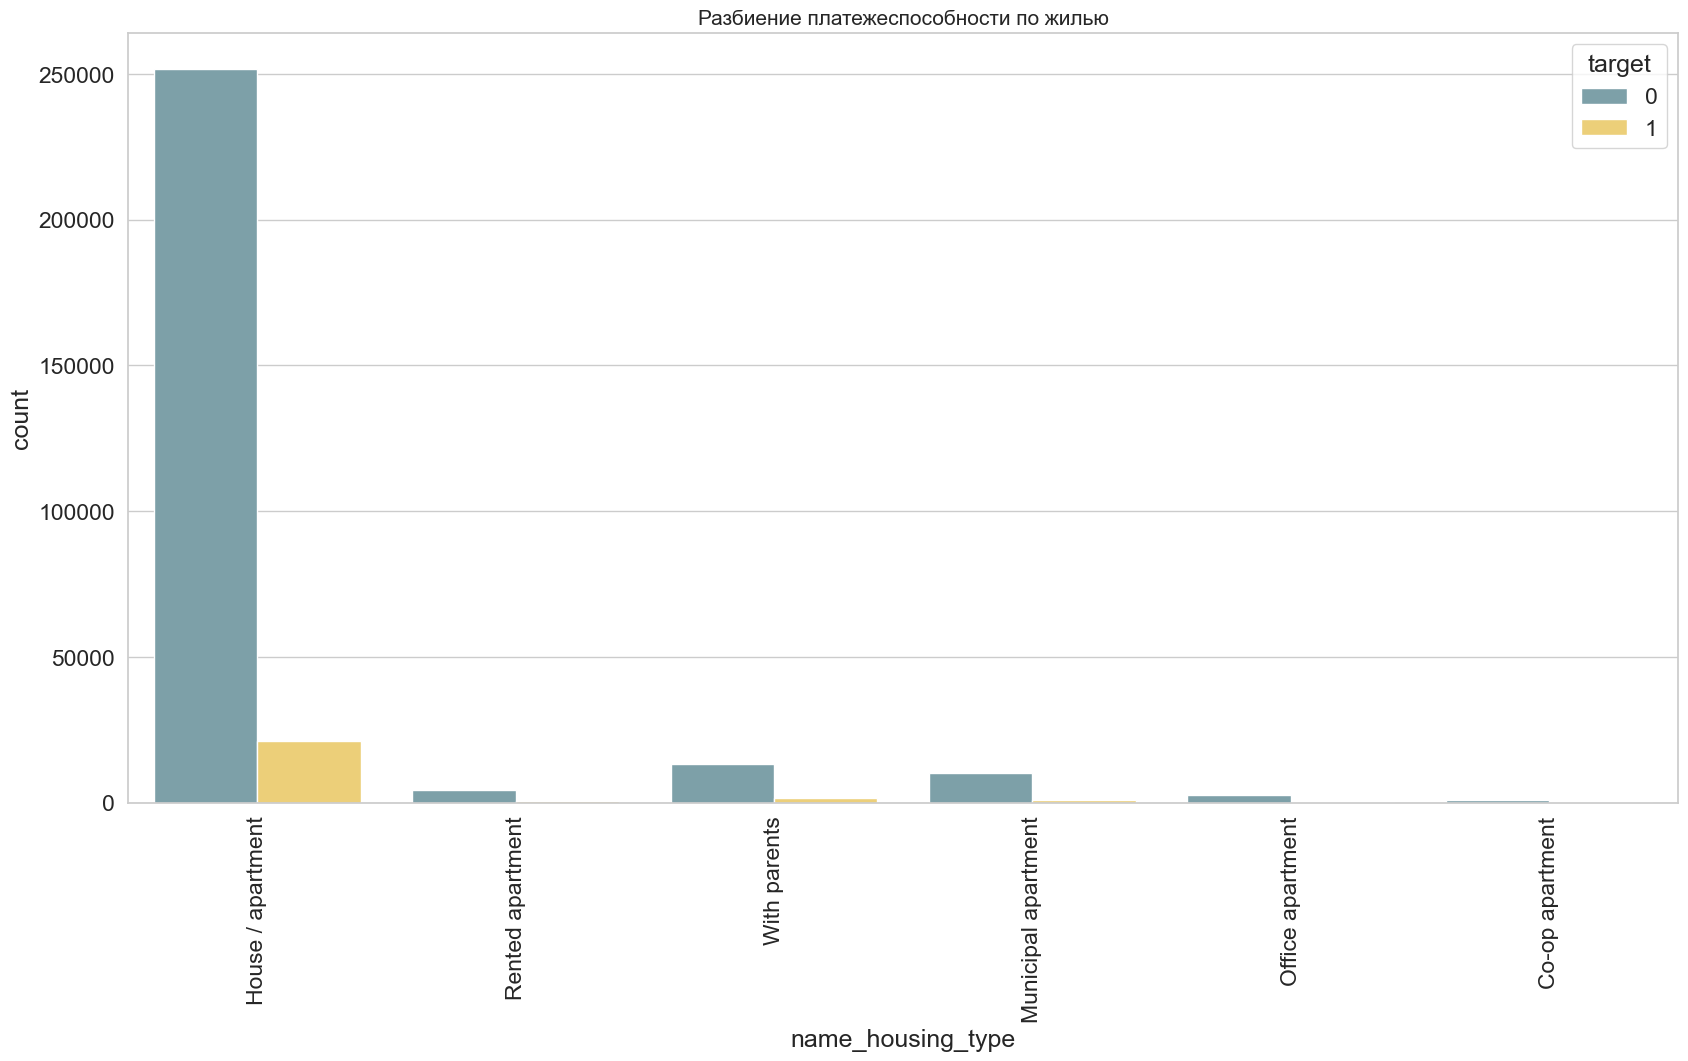

In [82]:
plt.figure(figsize=(20,10))
sns.countplot(data=data, x='name_housing_type', hue='target', palette=my_colors[5:7])
plt.xticks(rotation=90)
plt.title('Разбиение платежеспособности по жилью', size=15)
plt.show()

Text(0.5, 1.0, 'Распределение количества детей')

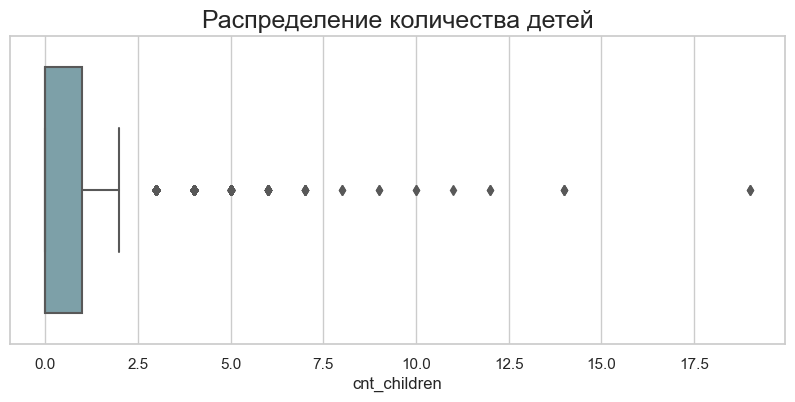

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
ax = sns.boxplot(data=data, x='cnt_children', color=my_colors[5])
plt.title('Распределение количества детей', fontsize=18)

Text(0.5, 1.0, 'Возраст клиента, на момент подачи заявления (относительно приложения)')

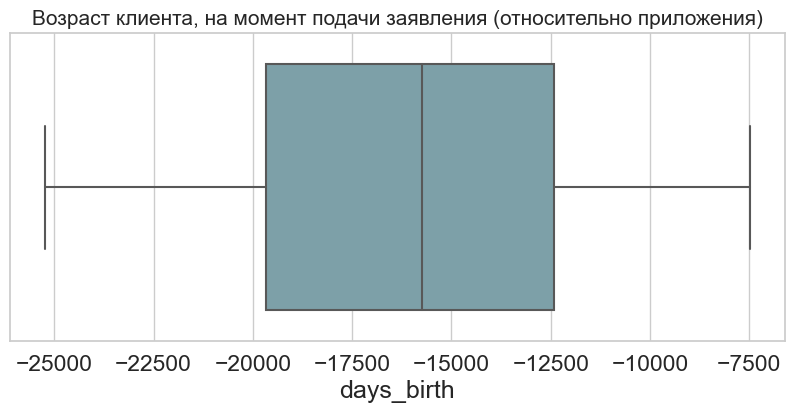

In [100]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
ax = sns.boxplot(data=data, x='days_birth', color=my_colors[5])
plt.title('Возраст клиента, на момент подачи заявления (относительно приложения)', fontsize=15)

#### хоть и невозможно понять возраст, оставила, так как все равно видно, что некоторая часть преобладает, и выбросов нет

Text(0.5, 1.0, 'Размер кредитов')

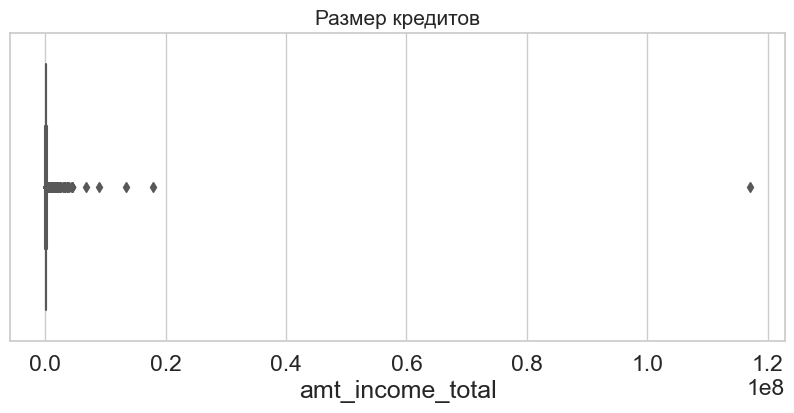

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
ax = sns.boxplot(data=data, x='amt_income_total', color=my_colors[5])
plt.title('Размер кредитов', fontsize=15)

Text(0.5, 1.0, 'Разбиение платежеспособности nо сфере работы ')

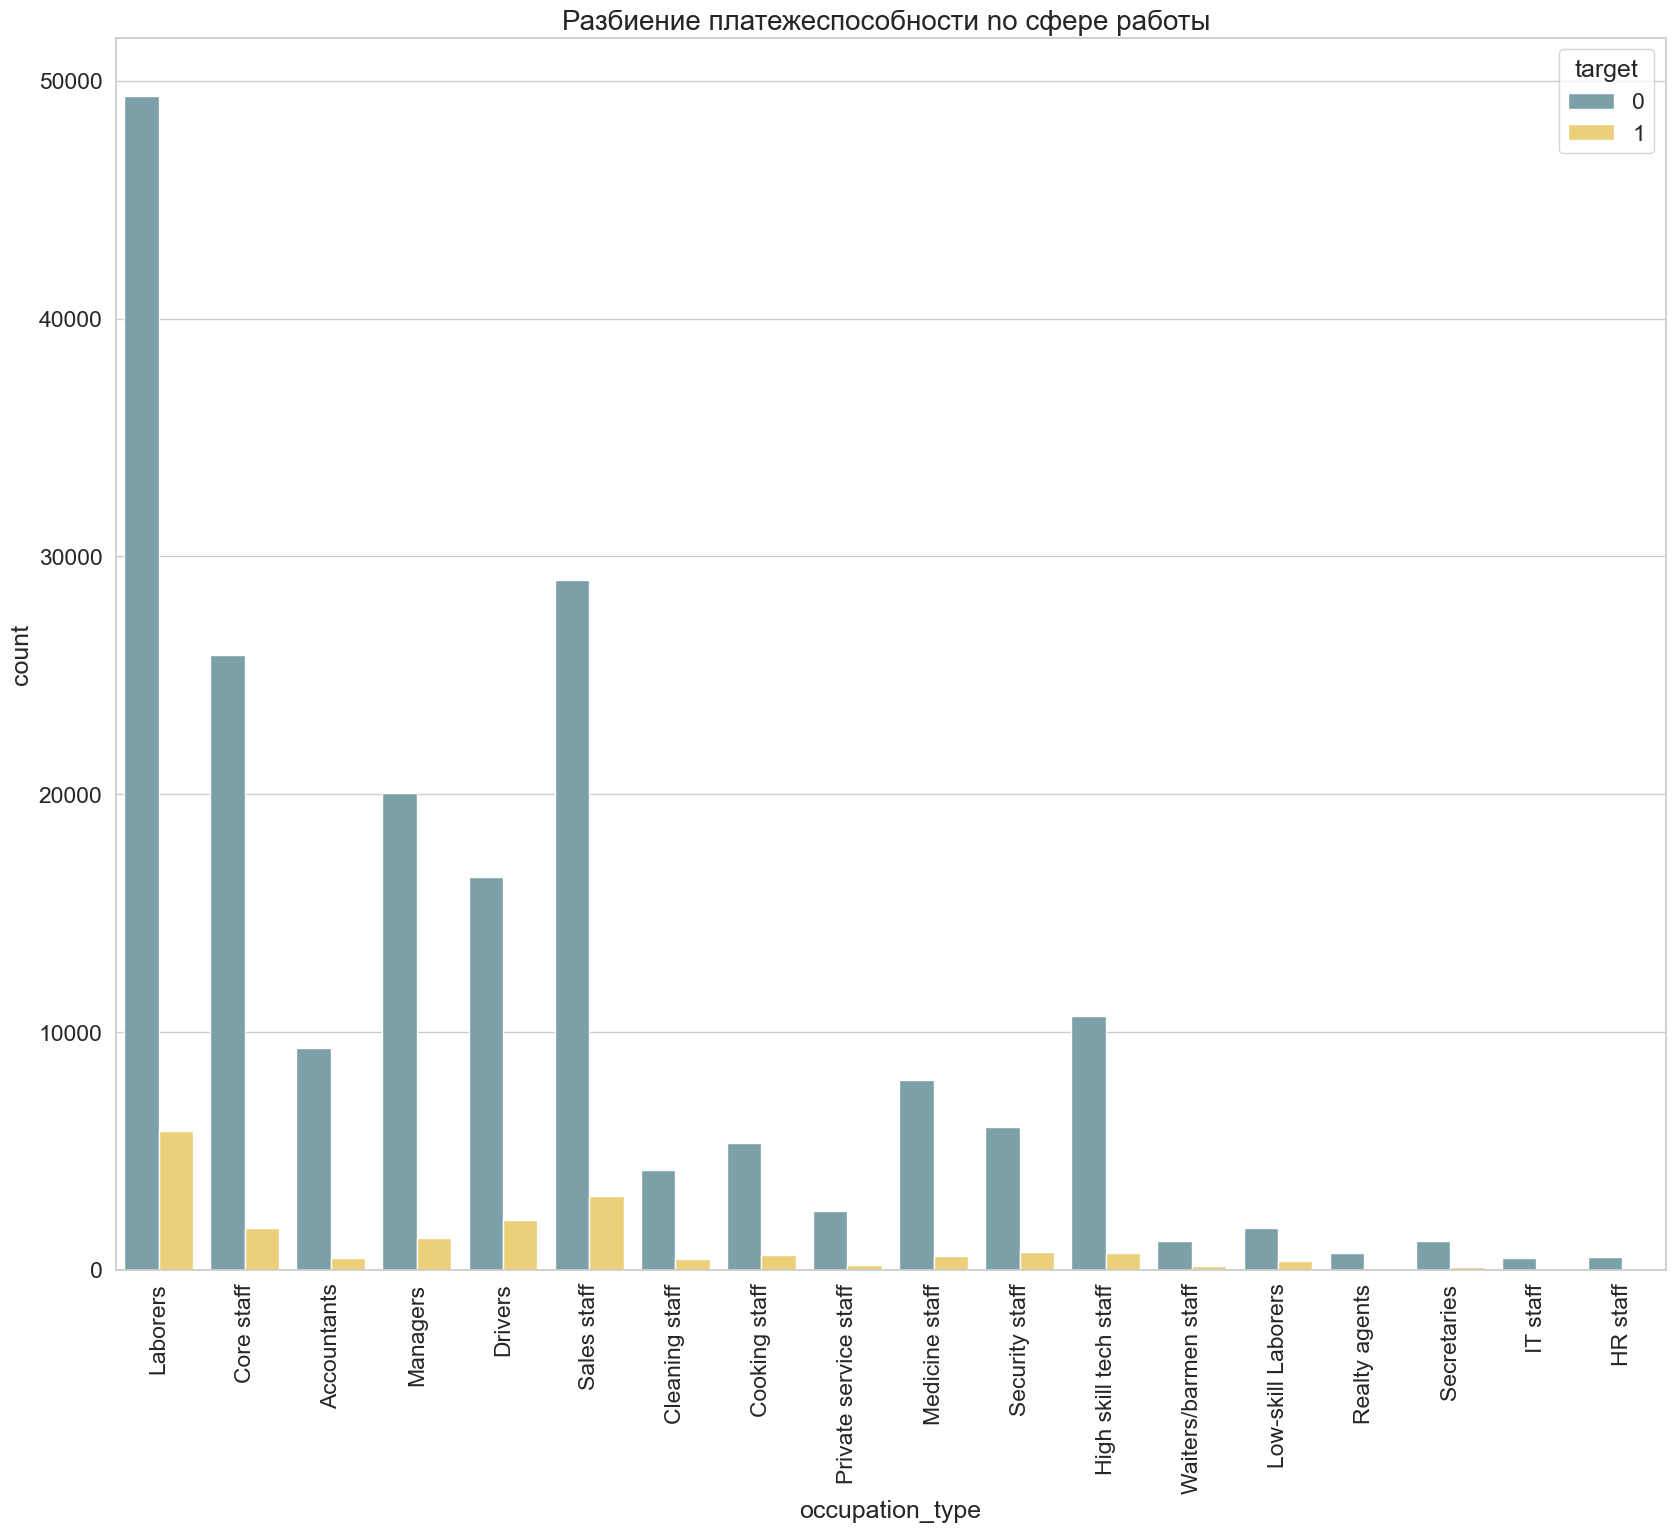

In [83]:
plt.figure(figsize=(20,16))
sns.countplot(data=data, x='occupation_type', hue='target', palette=my_colors[5:7])
plt.xticks(rotation=90)
plt.title('Разбиение платежеспособности nо сфере работы ', size=20)

### Узнаю можно ли удалять колонки с пропусками

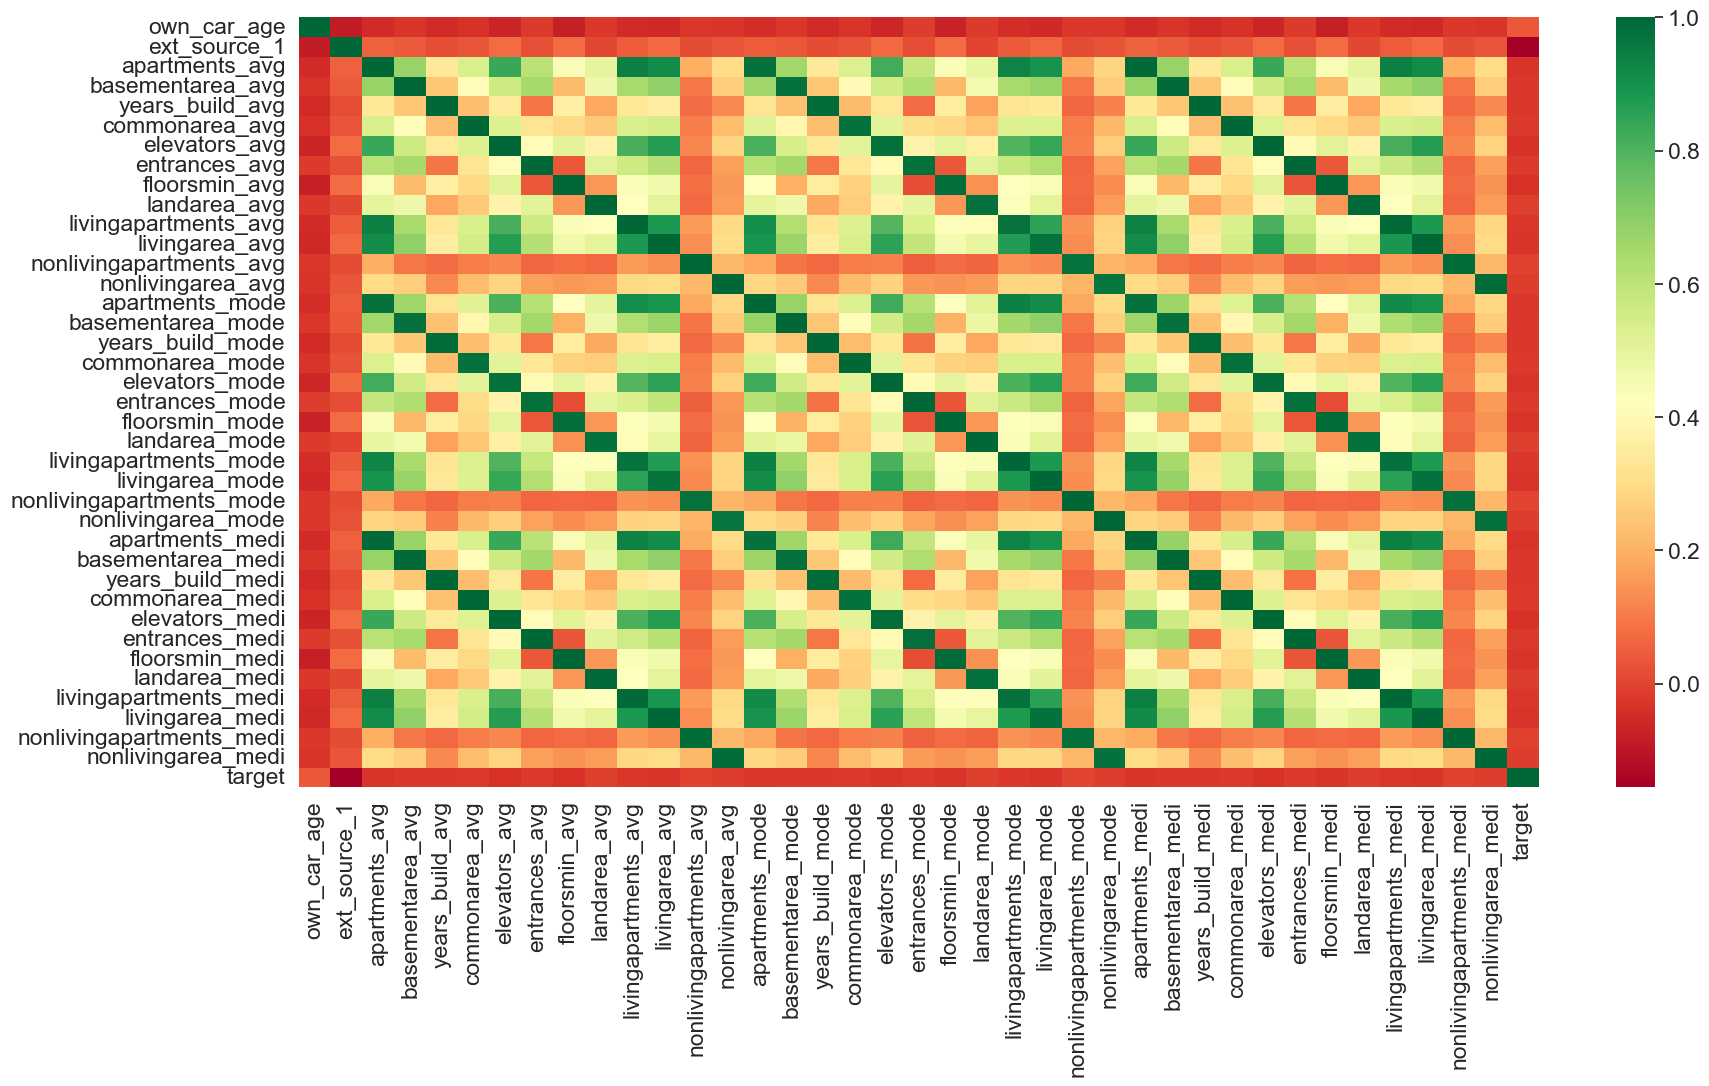

In [68]:
lost_col_data.append('target')
corr_data = data[lost_col_data]
corr1 = corr_data.corr()
ax = sns.heatmap(corr1,
            xticklabels=corr1.columns,
            yticklabels=corr1.columns,
            cmap ="RdYlGn")
lost_col_data.remove('target') 

#### Корреляции с целью почти нигде нет, больше всего связи с own_car_age, но тк там 66% пропусков, думаю тоже можно удалить. Также много ковариациции в колонках с описание жилья

# EDA с преобразованиями

In [13]:
data.drop(labels=lost_col_data,axis=1,inplace=True)

In [14]:
data_pr.drop(labels=lost_col_data_pr,axis=1,inplace=True)

In [15]:
combined_df= pd.merge(data, data_pr, on='sk_id_curr', how='inner')

In [81]:
combined_df

,sk_id_curr,target,name_contract_type_x,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit_x,amt_annuity_x,amt_goods_price_x,name_type_suite_x,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start_x,hour_appr_process_start_x,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,ext_source_3,years_beginexpluatation_avg,floorsmax_avg,years_beginexpluatation_mode,floorsmax_mode,years_beginexpluatation_medi,floorsmax_medi,totalarea_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_prev,name_contract_type_y,amt_annuity_y,amt_application,amt_credit_y,amt_goods_price_y,weekday_appr_process_start_y,hour_appr_process_start_y,flag_last_appl_per_contract,nflag_last_appl_in_day,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite_y,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1038818,Consumer loans,9251.775,179055.0,179055.0,179055.0,SATURDAY,9,Y,1,XAP,Approved,-606,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1810518,Cash loans,98356.995,900000.0,1035882.0,900000.0,FRIDAY,12,Y,1,XNA,Approved,-746,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2636178,Consumer loans,64567.665,337500.0,348637.5,337500.0,SUNDAY,17,Y,1,XAP,Approved,-828,Cash through the bank,XAP,Family,Refreshed,Furniture,POS,XNA,Stone,1400,Furniture,6.0,middle,POS industry with interest,365243.0,-79

In [83]:
combined_df.describe().applymap(lambda x: f"{x:0.3f}")

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit_x,amt_annuity_x,amt_goods_price_x,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start_x,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_2,ext_source_3,years_beginexpluatation_avg,floorsmax_avg,years_beginexpluatation_mode,floorsmax_mode,years_beginexpluatation_medi,floorsmax_medi,totalarea_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_prev,amt_annuity_y,amt_application,amt_credit_y,amt_goods_price_y,hour_appr_process_start_y,nflag_last_appl_in_day,days_decision,sellerplace_area,cnt_payment,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
count,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413608.000,1412493.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1411880.000,1171859.000,729019.000,715193.000,729019.000,715193.000,729019.000,715193.000,736160.000,1410555.000,1410555.000,1410555.000,1410555.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1413701.000,1250074.000,1250074.000,1250074.000,1250074.000,1250074.000,1250074.000,1413701.000,1106483.000,1413701.000,1413700.000,1094176.000,1413701.000,1413701.000,1413701.000,1413701.000,1106488.000,852595.000,852595.000,852595.000,852595.000,852595.000,852595.000
mean,278481.288,0.087,0.405,173316.044,587553.673,27017.016,527718.593,0.021,-16321.052,68702.027,-5003.233,-3034.563,1.000,0.806,0.182,0.999,0.283,0.072,2.151,2.060,2.038,11.984,0.012,0.044,0.036,0.074,0.222,0.174,0.511,0.490,0.977,0.222,0.977,0.219,0.977,0.222,0.100,1.544,0.154,1.526,0.108,-1084.701,0.000,0.739,0.000,0.014,0.089,0.000,0.074,0.003,0.000,0.002,0.000,0.002,0.001,0.001,0.006,0.000,0.004,0.000,0.000,0.000,0.006,0.007,0.039,0.301,0.362,2.913,1922744.331,15837.185,175243.594,196354.086,226451.191,12.479,0.996,-880.367,314.988,16.052,342257.657,13488.742,33274.832,76665.635,82353.172,0.331
std,102811.788,0.281,0.717,198573.372,384917.331,13951.165,353246.492,0.013,4344.557,145277.705,3551.051,1507.376,0.000,0.395,0.386,0.027,0.450,0.259,0.901,0.496,0.489,3.232,0.109,0.205,0.186,0.261,0.416,0.379,0.191,0.197,0.062,0.141,0.067,0.140,0.063,0.141,0.104,2.531,0.466,2.509,0.379,799.937,0.008,0.439,0.009,0.116,0.285,0.015,0.262,0.056,0.007,0.041,0.001,0.042,0.038,0.026,0.077,0.012,0.065,0.020,0.019,0.015,0.082,0.107,0.214,0.980,0.926,2.200,532715.335,14724.907,293622.193,319481.251,315937.604,3.331,0.060,783.540,7695.082,14.567,88832.267,71650.147,106161.776,149704.716,153537.064,0.470
min,100002.000,0.000,0.000,25650.000,45000.000,1615.500,40500.000,0.000,-25201.000,-17912.000,-24672.000,-7197.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

## Операции над числовыми данными

In [16]:
date_col = ['days_birth','days_employed','days_registration','days_id_publish', 'days_decision', 'days_termination',\
           'days_first_due', 'days_last_due_1st_version', 'days_last_due', 'days_termination']

for col in date_col:
    combined_df[col] = abs(combined_df[col])

In [34]:
combined_df2 = combined_df.copy()

In [35]:
df_for_grafic = combined_df.copy() 

In [36]:
combined_df2['age'] = combined_df2['days_birth'] // 365
df_for_grafic['age'] = df_for_grafic['days_birth'] // 365
bins = [10,20,30,40,50,60,70,80,90,100]

combined_df2['age_bins'] = np.searchsorted(bins, combined_df2.age.values, side='right')
df_for_grafic['age_bins'] = pd.cut(df_for_grafic['age'],bins=bins)

In [37]:
df_for_grafic['age_bins'].value_counts(normalize=True)*100

(30, 40]     26.578817
(40, 50]     24.656558
(50, 60]     22.668443
(20, 30]     15.255560
(60, 70]     10.840340
(10, 20]      0.000283
(70, 80]      0.000000
(80, 90]      0.000000
(90, 100]     0.000000
Name: age_bins, dtype: float64

#### В основном берут кредиты в возрасте 30-60 лет

In [38]:
combined_df2['days_employed'] = combined_df2['days_employed'] // 365
df_for_grafic['days_employed'] = df_for_grafic['days_employed'] // 365
bins = [5,10,15,20,25,30,35,40,45,50,55,60,65]

combined_df2['years_employed'] = np.searchsorted(bins, combined_df2.days_employed.values, side='right')
df_for_grafic['years_employed'] = pd.cut(df_for_grafic['days_employed'],bins=bins)

In [39]:
df_for_grafic['years_employed'].value_counts(normalize=True)*100

(5, 10]     57.802444
(10, 15]    22.562117
(15, 20]     9.372247
(20, 25]     5.121842
(25, 30]     2.727174
(30, 35]     1.652248
(35, 40]     0.596412
(40, 45]     0.154820
(45, 50]     0.010699
(50, 55]     0.000000
(55, 60]     0.000000
(60, 65]     0.000000
Name: years_employed, dtype: float64

#### Основными кредиторами являются люди с опытом работы 0-5 лет  - 58%, 22% с опытом 10-15 лет 

In [40]:
combined_df2['amt_income_total'] = combined_df2['amt_income_total']/100000
df_for_grafic['amt_income_total'] = df_for_grafic['amt_income_total']/100000

bins = [0,1,2,3,4,5,6,7,8,9,10,100]
labels = ['0-100т','100т-200т', '200т-300т','300т-400т','400т-500т','500т-600т','600т-700т','700т-800т',
       '800т-900т','900т-1м', 'больше 1м']
combined_df2['amt_income_bins'] = np.searchsorted(bins, combined_df2.amt_income_total.values, side='right')
df_for_grafic['amt_income_bins'] = pd.cut(df_for_grafic['amt_income_total'],bins=bins, labels = labels)

In [41]:
df_for_grafic['amt_income_bins'].value_counts(normalize=True)*100

100т-200т    51.123798
200т-300т    23.472860
0-100т       17.675753
300т-400т     5.215083
400т-500т     1.765382
500т-600т     0.354887
600т-700т     0.225439
800т-900т     0.071869
больше 1м     0.048596
700т-800т     0.039542
900т-1м       0.006791
Name: amt_income_bins, dtype: float64

#### 51% имеют доход от 100 до 200 тысяч

In [42]:
combined_df2['amt_credit_x'] = combined_df2['amt_credit_x']/100000
df_for_grafic['amt_credit_x'] = df_for_grafic['amt_credit_x']/100000
bins = [0,1,2,3,4,5,6,7,8,9,10,100]

combined_df2['amt_credit_bins'] = np.searchsorted(bins, combined_df2.amt_credit_x.values)
df_for_grafic['amt_credit_bins'] = pd.cut(df_for_grafic['amt_credit_x'],bins=bins, labels = labels)

In [29]:
df_for_grafic['amt_credit_bins'].value_counts(normalize=True)*100

200т-300т    17.871459
больше 1м    15.415353
500т-600т    11.345468
400т-500т    10.883490
100т-200т     9.280109
300т-400т     8.979056
600т-700т     7.832986
800т-900т     6.815585
700т-800т     6.393290
900т-1м       2.990802
0-100т        2.192401
Name: amt_credit_bins, dtype: float64

#### Преобладает с 18% кредитная сумма от 200 до 300 тысяч

In [211]:
combined_df2.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413701 entries, 0 to 1413700
Data columns (total 118 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    sk_id_curr                    int64  
 1    target                        int64  
 2    name_contract_type_x          object 
 3    code_gender                   object 
 4    flag_own_car                  object 
 5    flag_own_realty               object 
 6    cnt_children                  int64  
 7    amt_income_total              float64
 8    amt_credit_x                  float64
 9    amt_annuity_x                 float64
 10   amt_goods_price_x             float64
 11   name_type_suite_x             object 
 12   name_income_type              object 
 13   name_education_type           object 
 14   name_family_status            object 
 15   name_housing_type             object 
 16   region_population_relative    float64
 17   days_birth                    int64  
 18   

Text(0.5, 1.0, 'Разбиение платежеспособности по назначению кредита')

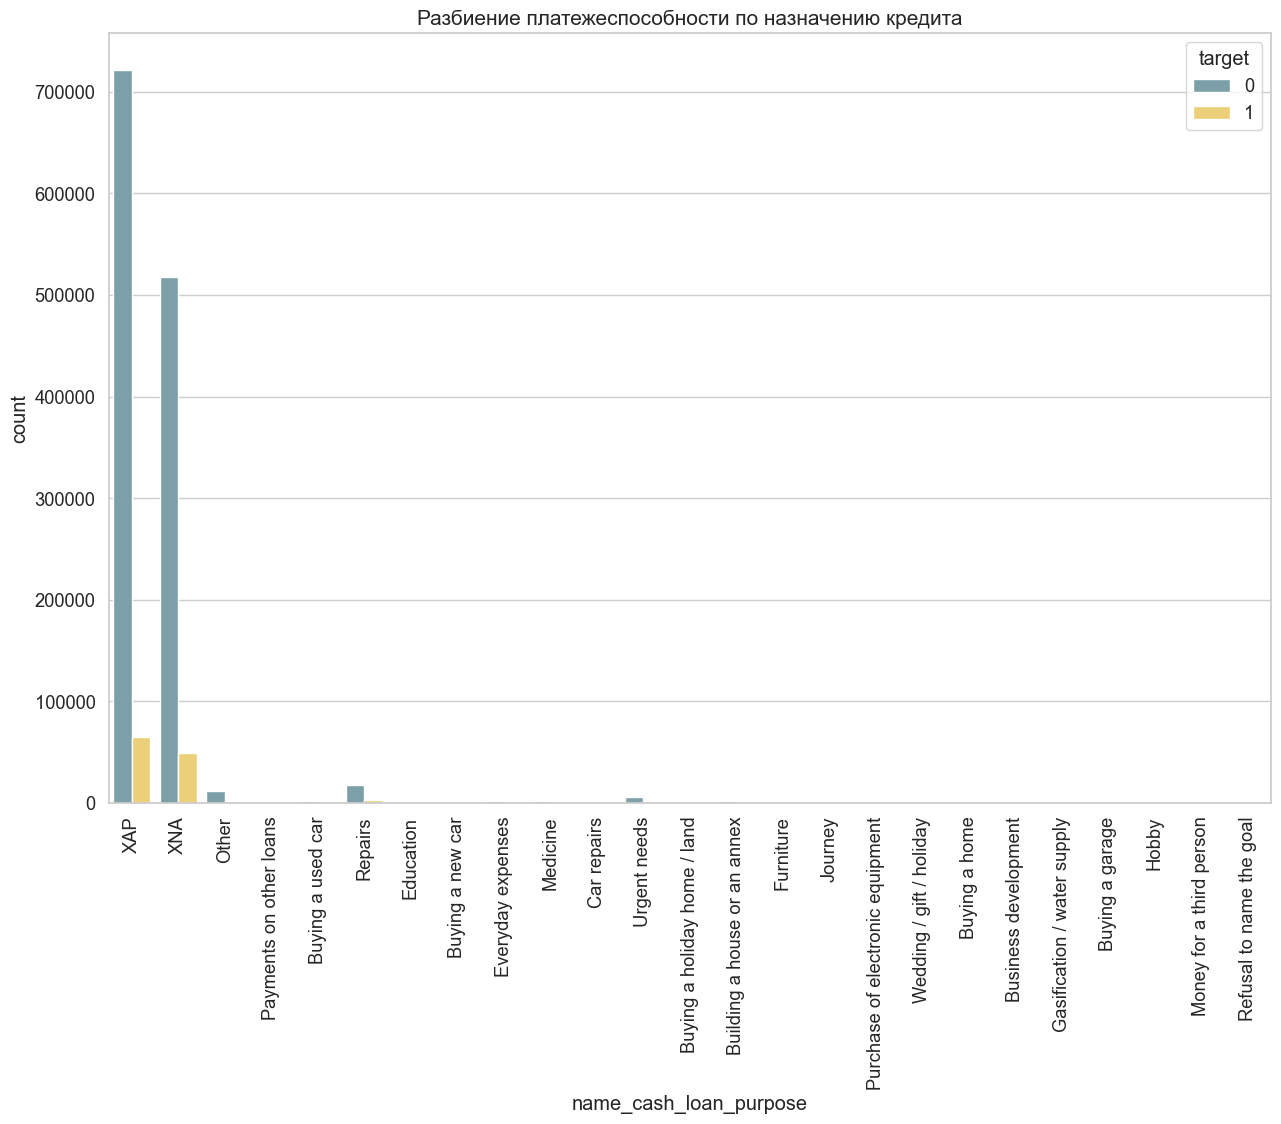

In [103]:
plt.figure(figsize=(15,10))

sns.countplot(data=combined_df2, x='name_cash_loan_purpose', hue='target', palette=my_colors[5:7] )
plt.xticks(rotation=90)
plt.title('Разбиение платежеспособности по назначению кредита', size=15)

Text(0.5, 1.0, 'Разбиение платежеспособности nо опыту работы')

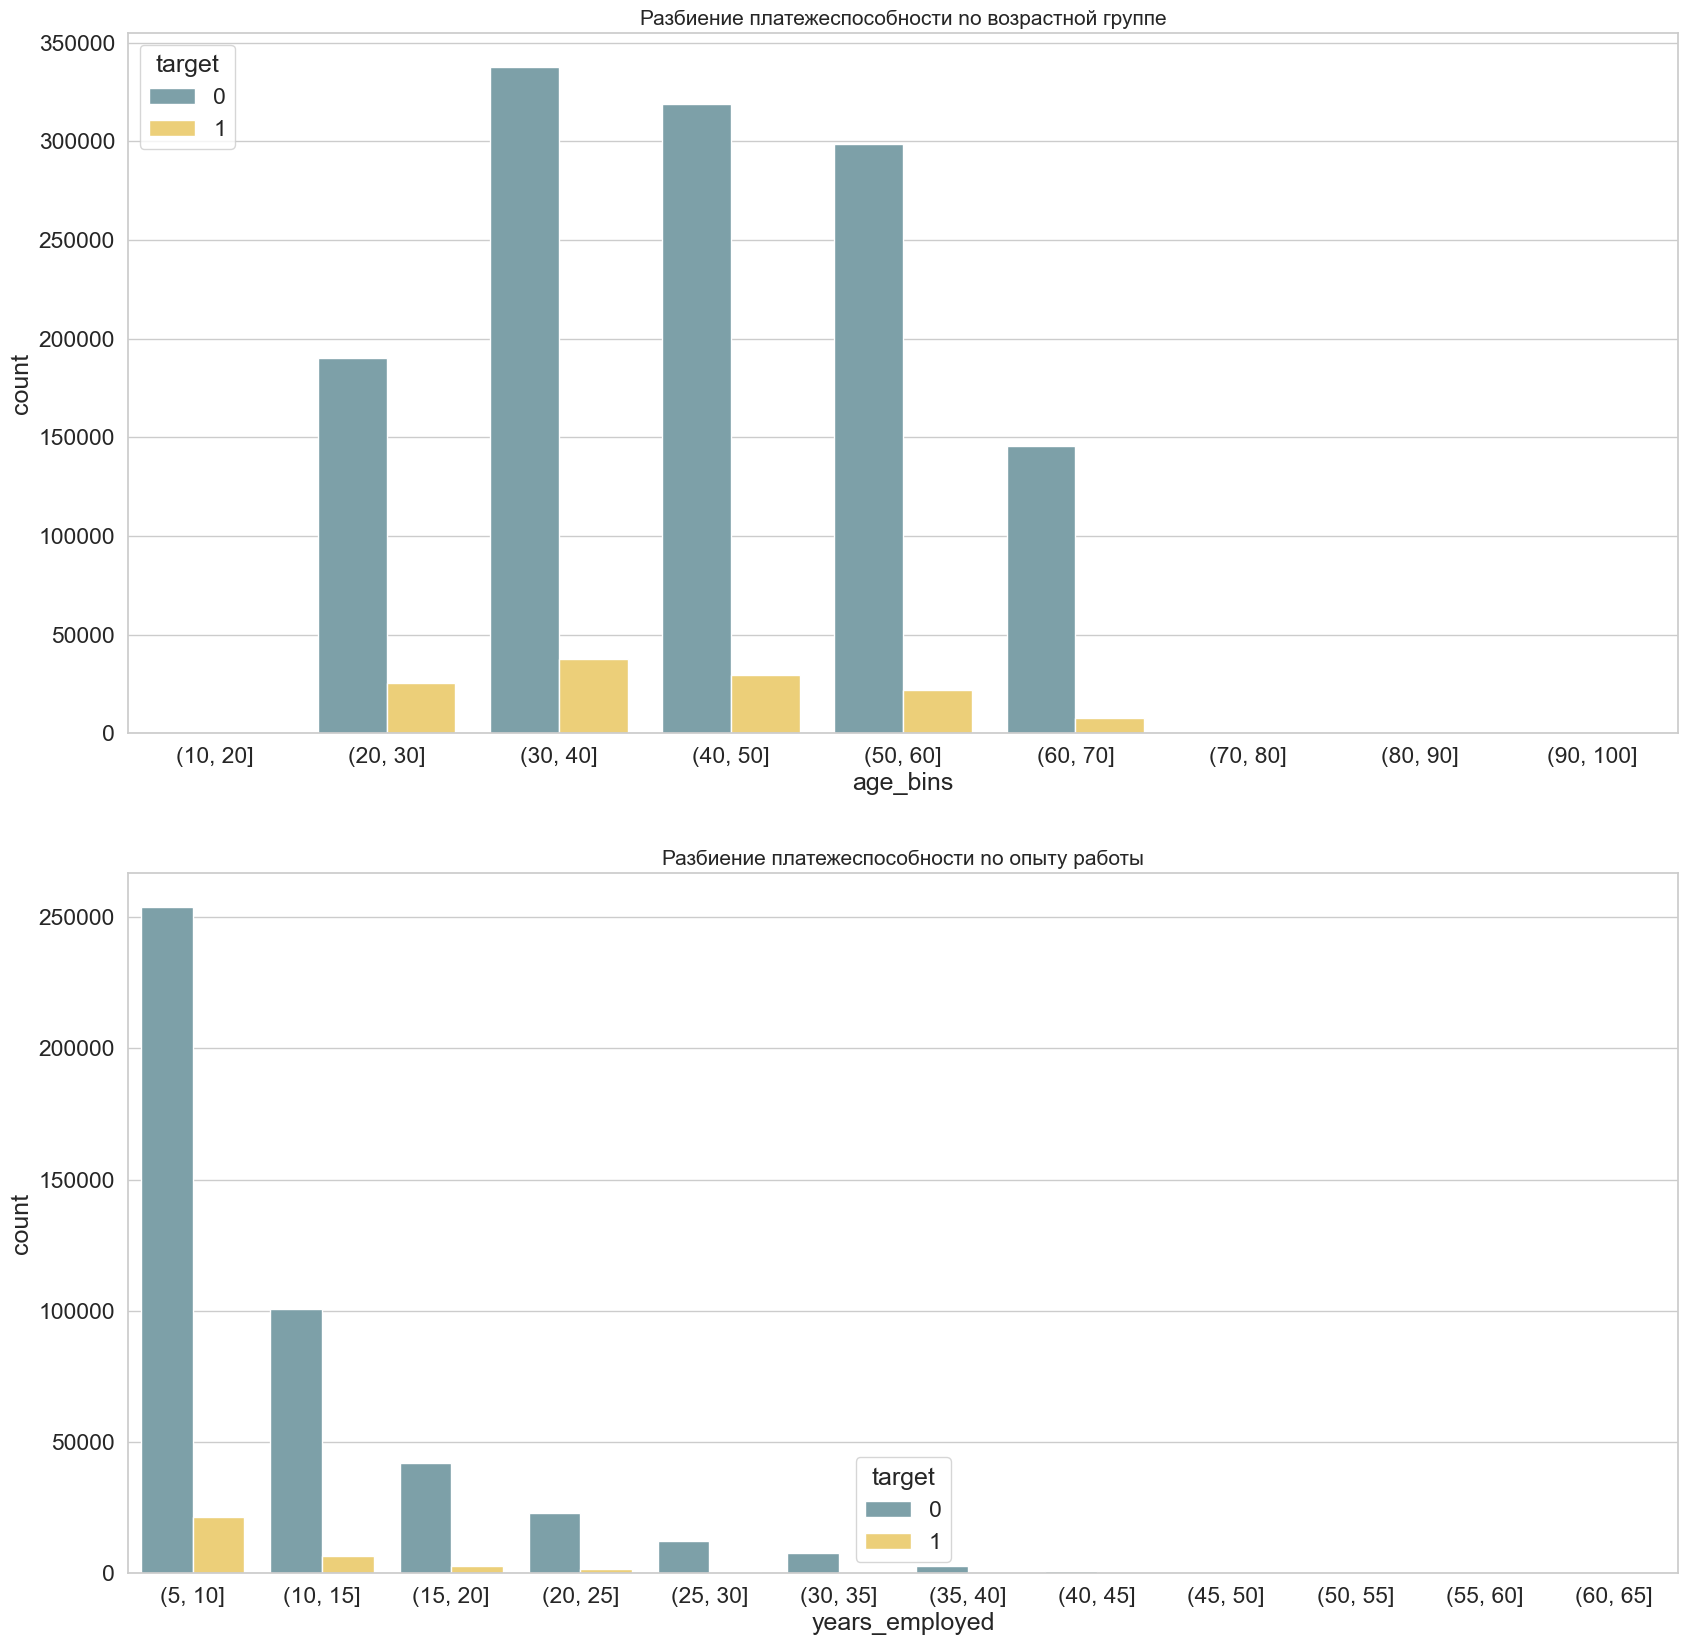

In [84]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.countplot(data=df_for_grafic, x='age_bins', hue='target', palette=my_colors[5:7])
plt.title('Разбиение платежеспособности nо возрастной группе', size=15)

plt.subplot(2,1,2)
sns.countplot(data=df_for_grafic, x='years_employed', hue='target', palette=my_colors[5:7])
plt.title('Разбиение платежеспособности nо опыту работы', size=15)

Text(0.5, 1.0, 'Разбиение платежеспособности nо размеру кредита')

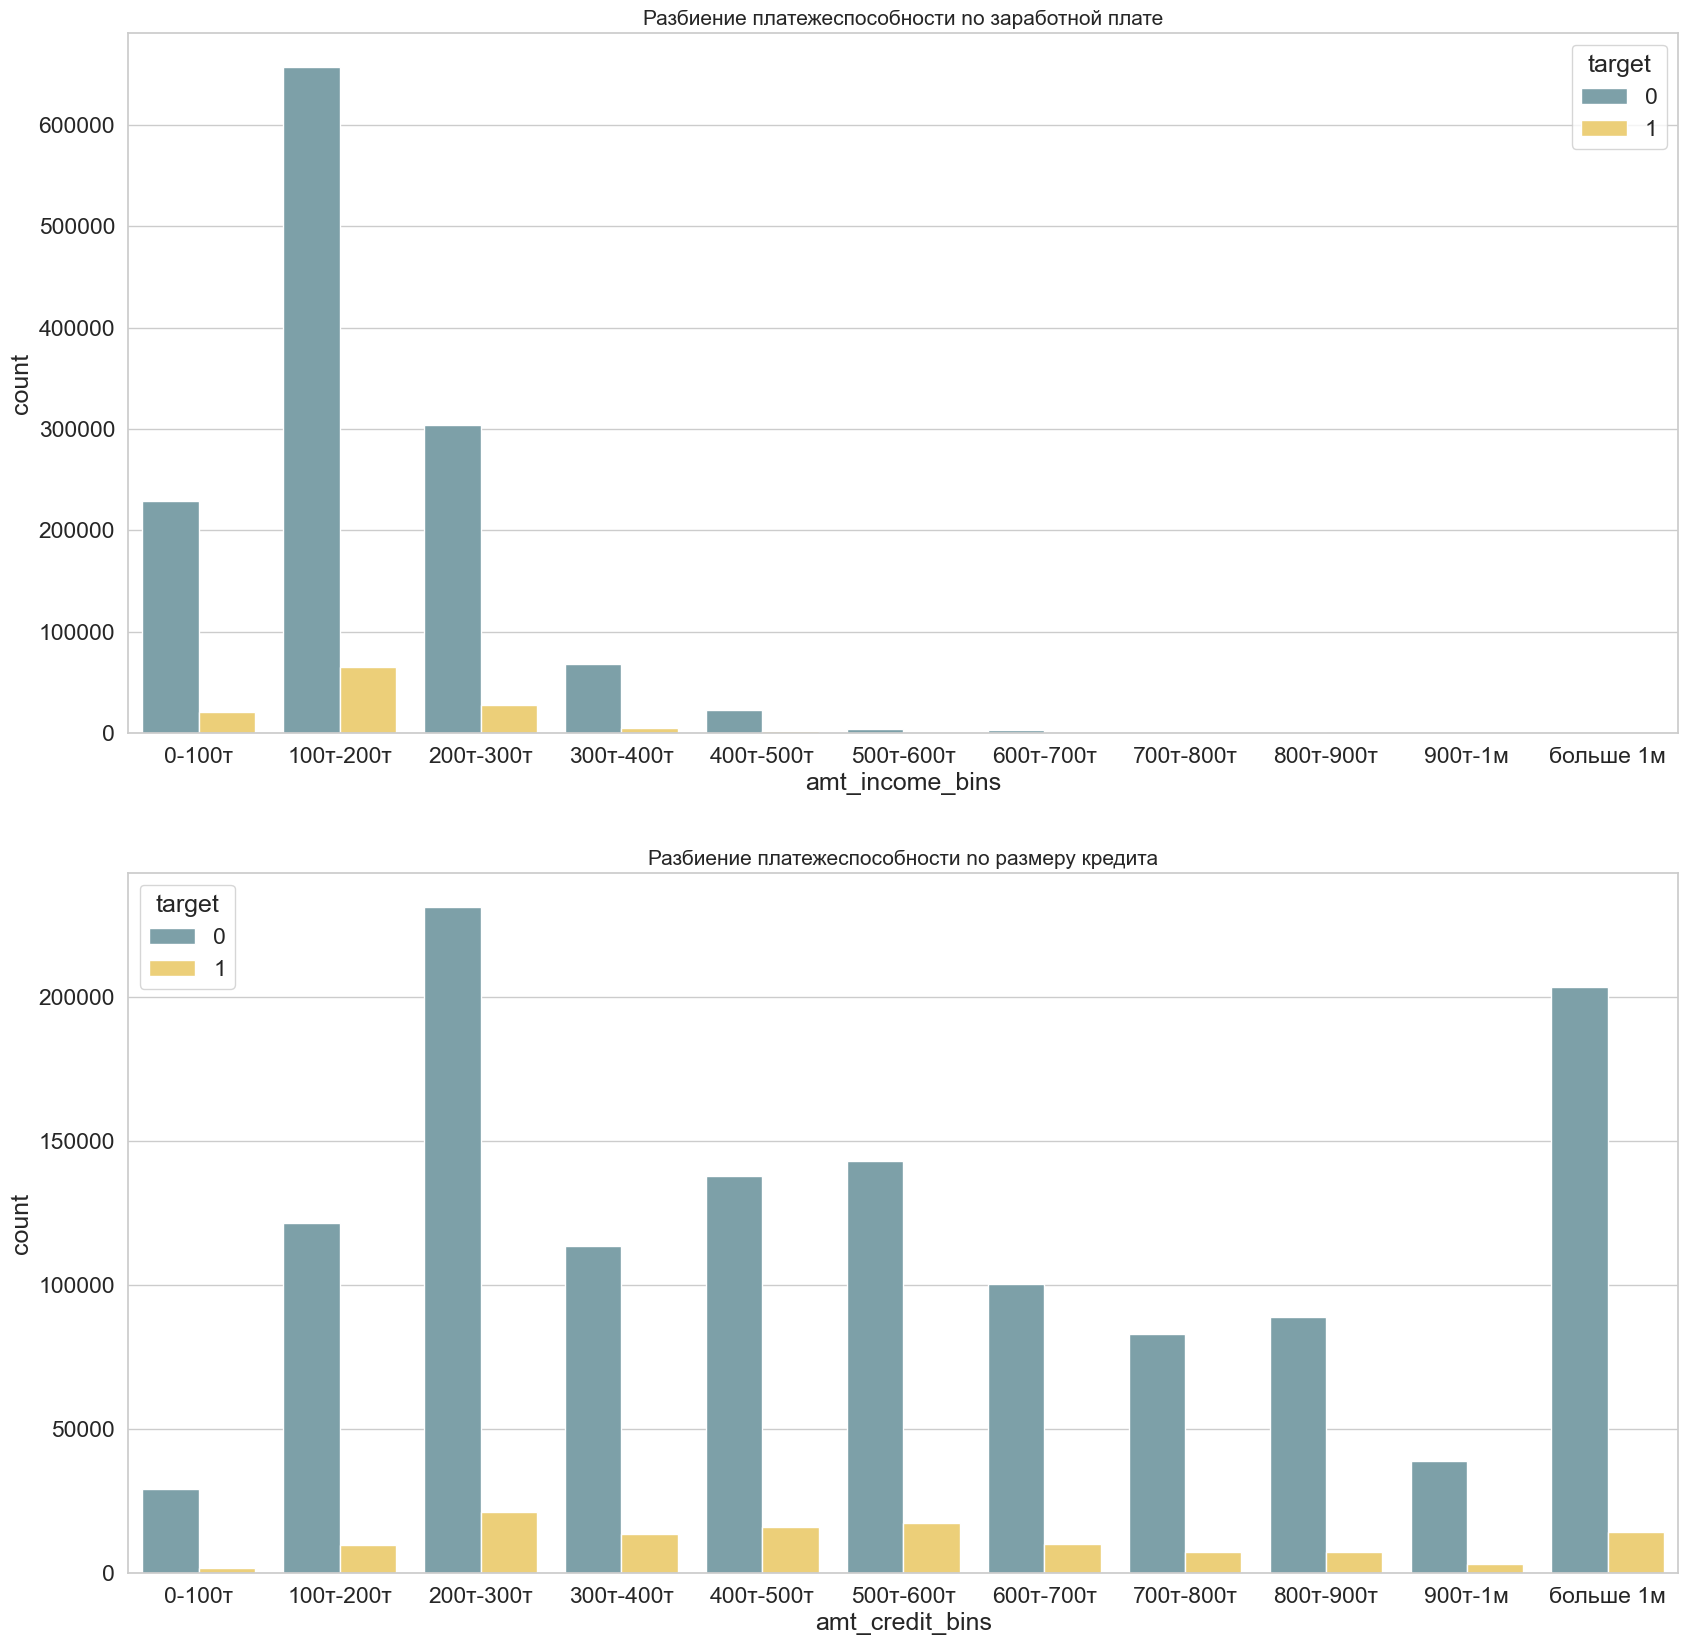

In [85]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.countplot(data=df_for_grafic, x='amt_income_bins', hue='target', palette=my_colors[5:7])
plt.title('Разбиение платежеспособности nо заработной плате', size=15)

plt.subplot(2,1,2)
sns.countplot(data=df_for_grafic, x='amt_credit_bins', hue='target', palette=my_colors[5:7])
plt.title('Разбиение платежеспособности nо размеру кредита', size=15)

In [246]:
combined_df2

,sk_id_curr,target,name_contract_type_x,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit_x,amt_annuity_x,amt_goods_price_x,name_type_suite_x,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start_x,hour_appr_process_start_x,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,ext_source_3,years_beginexpluatation_avg,floorsmax_avg,years_beginexpluatation_mode,floorsmax_mode,years_beginexpluatation_medi,floorsmax_medi,totalarea_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_prev,name_contract_type_y,amt_annuity_y,amt_application,amt_credit_y,amt_goods_price_y,weekday_appr_process_start_y,hour_appr_process_start_y,flag_last_appl_per_contract,nflag_last_appl_in_day,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite_y,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval,age,age_bins,years_employed,amt_income_bins,amt_credit_bins
0,100002,1,Cash loans,M,N,Y,0,2.025,0.000041,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,1,3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1038818,Consumer loans,9251.775,179055.0,179055.0,179055.0,SATURDAY,9,Y,1,XAP,Approved,606,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,565.0,125.0,25.0,17.0,0.0,25,2,0,3,1
1,100003,0,Cash loans,F,N,N,0,2.700,0.000129,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,3,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1810518,Cash loans,98356.995,900000.0,1035882.0,900000.0,FRIDAY,12,Y,1,XNA,Approved,746,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,716.0,386.0,536.0,527.0,1.0,45,4,0,3,1
2,100003,0,Cash loans,F,N,N,0,2.700,0.000129,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,3,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2636178,Consumer loans,64567.665,337500.0,348637.5,337500.0,SUNDAY,17,Y,1,XAP,Approved,828,Cash through the bank,XAP,Family,Refreshed,Furniture,POS,XNA,Stone,1400,Furniture,6.0,middl

## Итого по данным

1. Наблюдается дисбаланс целевой переменной, класс с платежеспособными намного больше
2. В основном берут кредиты женщины, наличными, на категории XPA, XNA, в возрасте 30-60 лет, с опытом работы 0-10 лет, с зарплатой от 100 до 200 тысяч на сумму 200-300 тысяч

### Категории у которых вероятность вернуть деньги выше:
1. Люди с высшим образованием
2. Женщины
3. Старше 50 лет 
4. С опытом работы больше 40 лет 
5. С доходом больше 700 тысяч

### Вероятность не вернуть деньги выше у:
1. Мужчины
2. Женатые или одинокие
3. Люди со средним или неполным средним образованием
4. Работающие в сфере транспорта, общественного питания, промышленность, самозанятые, чернорабочие
5. В возрасте 20-40 лет
6. Имеющие меньше 5 лет опыта работы

# Преобразования

In [322]:
combined_df3 = combined_df2.copy()

In [309]:
def get_labels(df, columns):
    '''Кодировка строковых данных'''
    for col in columns:
        df[col] = df[col].map({i:k for i,k in zip(df[col].dropna().unique(), range(len(df[col].dropna().unique())))})
    return df

In [300]:
columns = ['name_contract_type_x', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite_x', 'name_income_type', 'name_education_type',\
          'name_family_status', 'name_housing_type', 'occupation_type', 'weekday_appr_process_start_x', \
          'organization_type', 'name_contract_type_y', 'weekday_appr_process_start_y', 'flag_last_appl_per_contract', \
          'name_cash_loan_purpose', 'name_contract_status', 'name_payment_type', 'code_reject_reason', \
          'name_client_type', 'name_goods_category', 'name_portfolio', 'name_product_type', 'channel_type',\
          'name_seller_industry', 'name_yield_group', 'product_combination', 'name_type_suite_y', 'emergencystate_mode']

In [323]:
combined_df3 = get_labels(combined_df3, columns) 

In [291]:
combined_df3

,sk_id_curr,target,name_contract_type_x,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit_x,amt_annuity_x,amt_goods_price_x,name_type_suite_x,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start_x,hour_appr_process_start_x,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,ext_source_3,years_beginexpluatation_avg,floorsmax_avg,years_beginexpluatation_mode,floorsmax_mode,years_beginexpluatation_medi,floorsmax_medi,totalarea_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,sk_id_prev,name_contract_type_y,amt_annuity_y,amt_application,amt_credit_y,amt_goods_price_y,weekday_appr_process_start_y,hour_appr_process_start_y,flag_last_appl_per_contract,nflag_last_appl_in_day,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite_y,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval,age,age_bins,years_employed,amt_income_bins,amt_credit_bins
0,100002,1,0,0,0,0,0,2.025,0.000041,24700.5,351000.0,0.0,0,0,0,0,0.018801,9461,1,3648.0,2120,1,1,0,1,1,0,0.0,1.0,2,2,0,10,0,0,0,0,0,0,0,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1038818,0,9251.775,179055.0,179055.0,179055.0,0,9,0,1,0,0,606,0,0,NaN,0,0,0,0,0,500,0,24.0,0,0.0,365243.0,565.0,125.0,25.0,17.0,0.0,25,2,0,3,1
1,100003,0,0,1,0,1,0,2.700,0.000129,35698.5,1129500.0,1.0,1,1,1,0,0.003541,16765,3,1186.0,291,1,1,0,1,1,0,1.0,2.0,1,1,1,11,0,0,0,0,0,0,1,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1810518,1,98356.995,900000.0,1035882.0,900000.0,1,12,0,1,1,0,746,0,0,0.0,1,1,1,1,1,-1,1,12.0,0,1.0,365243.0,716.0,386.0,536.0,527.0,1.0,45,4,0,3,1
2,100003,0,0,1,0,1,0,2.700,0.000129,35698.5,1129500.0,1.0,1,1,1,0,0.003541,16765,3,1186.0,291,1,1,0,1,1,0,1.0,2.0,1,1,1,11,0,0,0,0,0,0,1,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2636178,0,64567.665,337500.0,348637.5,337500.0,2,17,0,1,0,0,828,1,0,1.0,2,2,0,0,0,1400,2,6.0,1,2.0,365243.0,797.0,647.0,647.0,639.0,0.0,45,4,0,3,1
3,100003,0,0,1,0,1,0,2.700,0.000129,35698.5,1129500.0,1.0,1,1,1,0,0.003541,16765,3,1186.0,291,1,1,0,1,1,0,1.0,2.0,1,1,1,11,0,0,0,0,0,0,1,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2396755,0,6737.310,68809.5,68053.5,68809.5,0,15,0,1,0,0,2341,1,0,1.0,2,3,0,0,2,200,3,12.0,1,3.0,365243.0,2310.0,1980.0,1980.0,1976.0,1.0,45,4,0,3,1
4,100004,0,1,0,1,0,0,0.675,0.000014,6750.0,135000.0,0.0,0,0,0,0,0.010

### Заполнение пропусков
так как много выбросов применю многомерное заполнение

In [319]:
lost_col_df = find_missing_values(combined_df3, 0)

Колонки с долей пропущенных значений больше 0%
amt_annuity_x - 0.0066%
amt_goods_price_x - 0.0854%
name_type_suite_x - 0.2494%
occupation_type - 32.3675%
ext_source_2 - 0.1288%
ext_source_3 - 17.107%
years_beginexpluatation_avg - 48.4319%
floorsmax_avg - 49.4099%
years_beginexpluatation_mode - 48.4319%
floorsmax_mode - 49.4099%
years_beginexpluatation_medi - 48.4319%
floorsmax_medi - 49.4099%
totalarea_mode - 47.9268%
emergencystate_mode - 47.0645%
obs_30_cnt_social_circle - 0.2225%
def_30_cnt_social_circle - 0.2225%
obs_60_cnt_social_circle - 0.2225%
def_60_cnt_social_circle - 0.2225%
amt_req_credit_bureau_hour - 11.5744%
amt_req_credit_bureau_day - 11.5744%
amt_req_credit_bureau_week - 11.5744%
amt_req_credit_bureau_mon - 11.5744%
amt_req_credit_bureau_qrt - 11.5744%
amt_req_credit_bureau_year - 11.5744%
amt_annuity_y - 21.7315%
amt_credit_y - 0.0001%
amt_goods_price_y - 22.602%
name_type_suite_y - 49.1385%
cnt_payment - 21.7311%
product_combination - 0.0221%
days_first_drawing - 39.

In [321]:
imputer = IterativeImputer()
def fill_nan(df, columns):
    for col in columns:
        df[col] = imputer.fit_transform(df[[col]])
    return df

In [324]:
combined_df3 = fill_nan(combined_df3, lost_col_df)

In [325]:
round(combined_df3.isnull().sum()/len(combined_df3)*100, 2) #процент пропущенных значений

sk_id_curr                      0.0
target                          0.0
name_contract_type_x            0.0
code_gender                     0.0
flag_own_car                    0.0
flag_own_realty                 0.0
cnt_children                    0.0
amt_income_total                0.0
amt_credit_x                    0.0
amt_annuity_x                   0.0
amt_goods_price_x               0.0
name_type_suite_x               0.0
name_income_type                0.0
name_education_type             0.0
name_family_status              0.0
name_housing_type               0.0
region_population_relative      0.0
days_birth                      0.0
days_employed                   0.0
days_registration               0.0
days_id_publish                 0.0
flag_mobil                      0.0
flag_emp_phone                  0.0
flag_work_phone                 0.0
flag_cont_mobile                0.0
flag_phone                      0.0
flag_email                      0.0
occupation_type             

# Обучение модели и предсказание

In [329]:
train_data = combined_df3.copy()
train_data.drop(labels='target',axis=1,inplace=True)
target = combined_df3['target']

In [332]:
X_train, X_test, y_train, y_test  = train_test_split(train_data, target, test_size = 0.2, \
                                                     random_state=42)

### Метриками качества будут нечувствутельные к выбросам f1, log loss, PR AUC

In [334]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    
    print(f'f1 score: {score}')    
    return score

### Изза большого датасета, не смогу применить SVM, KNN, XGBoost, CatBoost, LogisticRegression и нейронки, так как они вычислительно тяжелые, остановлюсь на относительно простом, но эффективном

In [345]:
parameters_DT ={'max_depth' :[ 30, 50, 70, 100],
         'random_state' : [0, 10, 20, 30, 40, 50],
         'min_samples_split' : [ 18, 20, 24, 30 ]}   

In [346]:
def train_with_DecisionTreeClassifier(hyperparameters, X_train, X_test, y_train, y_test):
    keys = hyperparameters.keys()
    best_index = {key:0 for key in keys}
    best_model = None
    best_score = 0
    for (index, key) in enumerate(keys):
        print("Find best parameter for %s" %(key))
        items = hyperparameters[key]
        best_parameter = None
        temp_best = 0
        for (key_index, item) in enumerate(items):
            max_depth = hyperparameters['max_depth'][best_index['max_depth']] if key != 'max_depth' else item
            min_samples_split = hyperparameters['min_samples_split'][best_index['min_samples_split']] \
            if key != 'min_samples_split' else item
            random_state = hyperparameters["random_state"][best_index["random_state"]] if key != "random_state" else item 
            print("Training with max_depth: %d min_samples_split: %.2f random_state:%d"%(max_depth, min_samples_split, random_state))
            DT = DecisionTreeClassifier(
                max_depth = max_depth, 
                min_samples_split = min_samples_split,
                random_state=random_state
            )
            DT.fit(X_train, y_train)
            score = evaluate(DT, X_test, y_test)
            
            if score > temp_best:
                temp_best = score
                best_index[key] = key_index
                best_parameter = item
            if score > best_score:
                best_score = score
                best_model = DT
        print("Best Parameter for %s: "%(key), best_parameter)
    best_parameters = {
        'max_depth': hyperparameters['max_depth'][best_index['max_depth']],
        'min_samples_split': hyperparameters['min_samples_split'][best_index['min_samples_split']],
        "random_state": hyperparameters["random_state"][best_index["random_state"]]
    }
    return best_model, best_score, best_parameters
best_model_DT, best_score_DT, best_parameters_DT = train_with_DecisionTreeClassifier(parameters_DT, X_train, X_test, y_train, y_test)

Find best parameter for max_depth
Training with max_depth: 30 min_samples_split: 18.00 random_state:0
0.8002986516755236
Training with max_depth: 50 min_samples_split: 18.00 random_state:0
0.8394543982394586
Training with max_depth: 70 min_samples_split: 18.00 random_state:0
0.8399185674519091
Training with max_depth: 100 min_samples_split: 18.00 random_state:0
0.8399185674519091
Best Parameter for max_depth:  70
Find best parameter for random_state
Training with max_depth: 70 min_samples_split: 18.00 random_state:0
0.8399185674519091
Training with max_depth: 70 min_samples_split: 18.00 random_state:10
0.8398122767671734
Training with max_depth: 70 min_samples_split: 18.00 random_state:20
0.8395825119830681
Training with max_depth: 70 min_samples_split: 18.00 random_state:30
0.8395020746887967
Training with max_depth: 70 min_samples_split: 18.00 random_state:40
0.8402782103186962
Training with max_depth: 70 min_samples_split: 18.00 random_state:50
0.8397469142205165
Best Parameter for 

In [347]:
print("Best f1: ", f'{best_score_DT}%')
print("Best Parameters: ", best_parameters_DT)

Best f1:  0.8402782103186962%
Best Parameters:  {'max_depth': 70, 'min_samples_split': 18, 'random_state': 40}


In [351]:
predictions_DT = best_model_DT.predict(X_test)
f1_DT = f1_score(y_test,predictions_DT, average='weighted')
log_loss_DT = log_loss(y_test,predictions_DT)

In [352]:
print("F1-score: {:.4f}".format(f1_DT))
print("Log loss-score: {:.4f}".format(log_loss_DT))

F1-score: 0.9726
Log loss-score: 0.9398


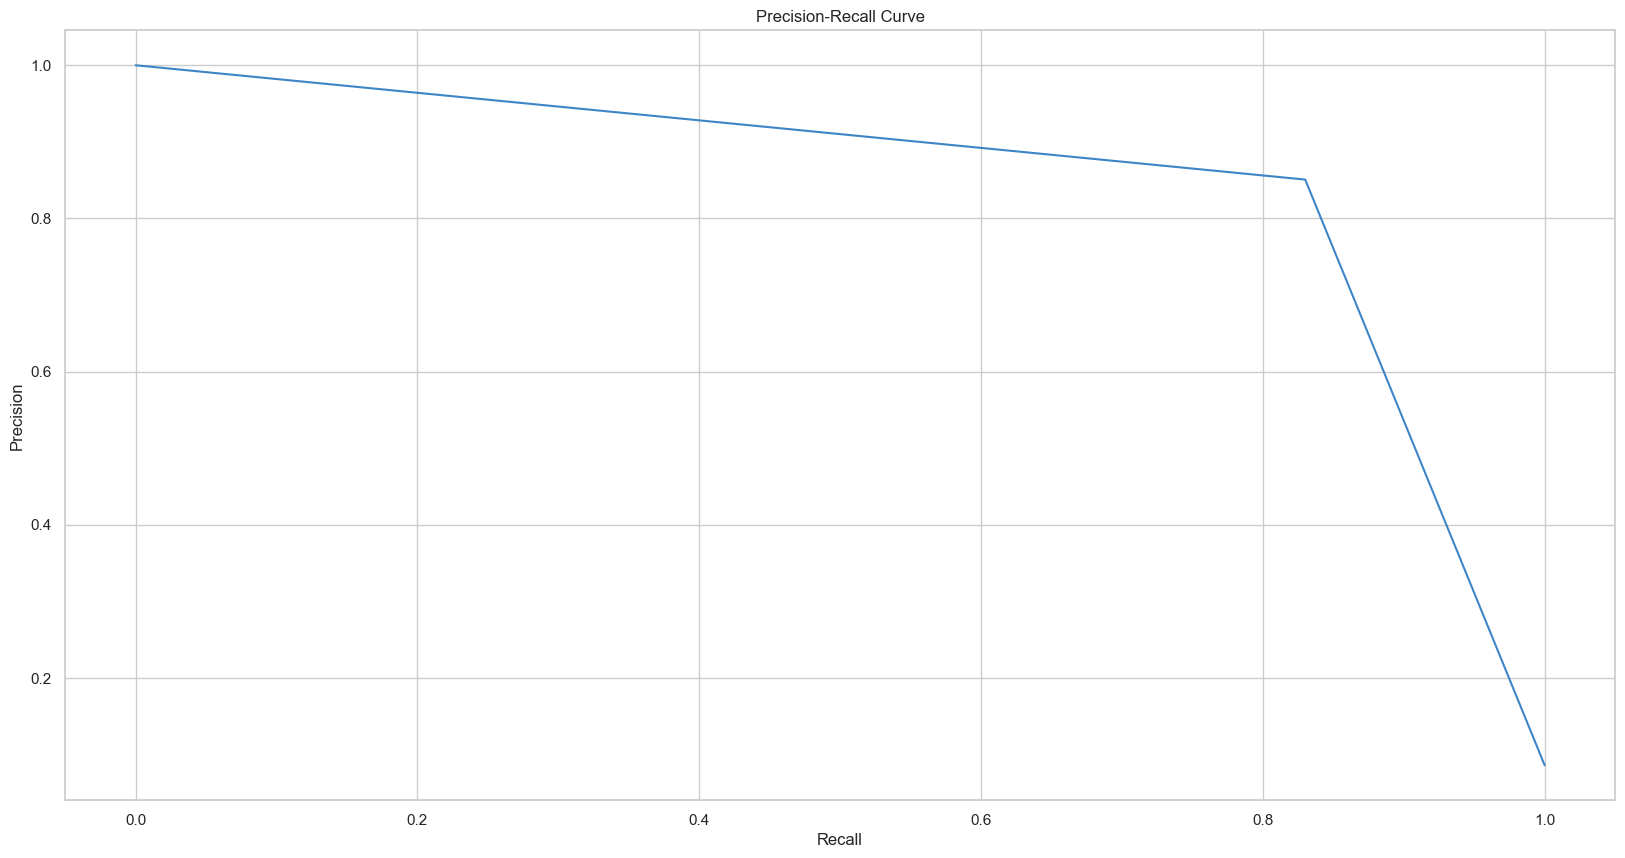

In [353]:
precision, recall, thresholds = precision_recall_curve(y_test,predictions_DT)

fig, ax = plt.subplots()
ax.plot(recall, precision, color=my_colors[0])

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show() 

#### Очень хорошо